In [254]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (StandardScaler, LabelEncoder, OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [255]:
data = pd.read_csv("train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


Посмотрим общую информацию по каждой переменной в нашем датасете, определим сколько пропущенных значений в нем находится. 

In [256]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [257]:
data.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


Посчитаем точное количество пропущенных значений в каждой переменной.

In [258]:
data.isna().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

Заметим, что в столбце `key`, `popularity`, `instrumentalness` имеем пропущенные значения. 
Далее разберем два случая: в первом мы удалим эти записи из нашего датасета, а во втором постараемся оставить часть из них.  

In [259]:
data_without_na = data.dropna()

Посмотрим на количество уникальных элементов в каждой переменной и на основе 
этого выделим категориальные переменные. В нашей случае примем, что все переменные с 11 и меньше уникальными значениями будут категориальными.

In [260]:
data_without_na.nunique()

Artist Name            6703
Track Name            10002
Popularity               97
danceability            873
energy                 1147
key                      11
loudness               7121
mode                      2
speechiness            1092
acousticness           3578
instrumentalness       4032
liveness               1342
valence                1263
tempo                  9283
duration_in min/ms     9545
time_signature            4
Class                    11
dtype: int64

Сделаем список с именами категориальных переменных для дальнейшего перекодирования. 

In [261]:
cat_features = []
for column in data_without_na.columns:
    if len(data_without_na[column].unique()) <= 11:
        cat_features.append(column)
cat_features

['key', 'mode', 'time_signature', 'Class']

Также сделаем список с числовыми переменными, которые мы впоследствии стандартизуем. 

In [262]:
num_features = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms']

Посмотрим на распределения нашихт числовых переменных. 

In [263]:
def draw_histplot(df, columns, nrows, ncols, n):
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(40, 20))

    # Создаем график для каждой колонки
    for i, column in enumerate(columns):
        row = i // n
        col = i % n
        axes[row, col].hist(df[column])
        axes[row, col].set_title(column, size=50)

    # Отображаем графики
    plt.tight_layout()
    plt.show()

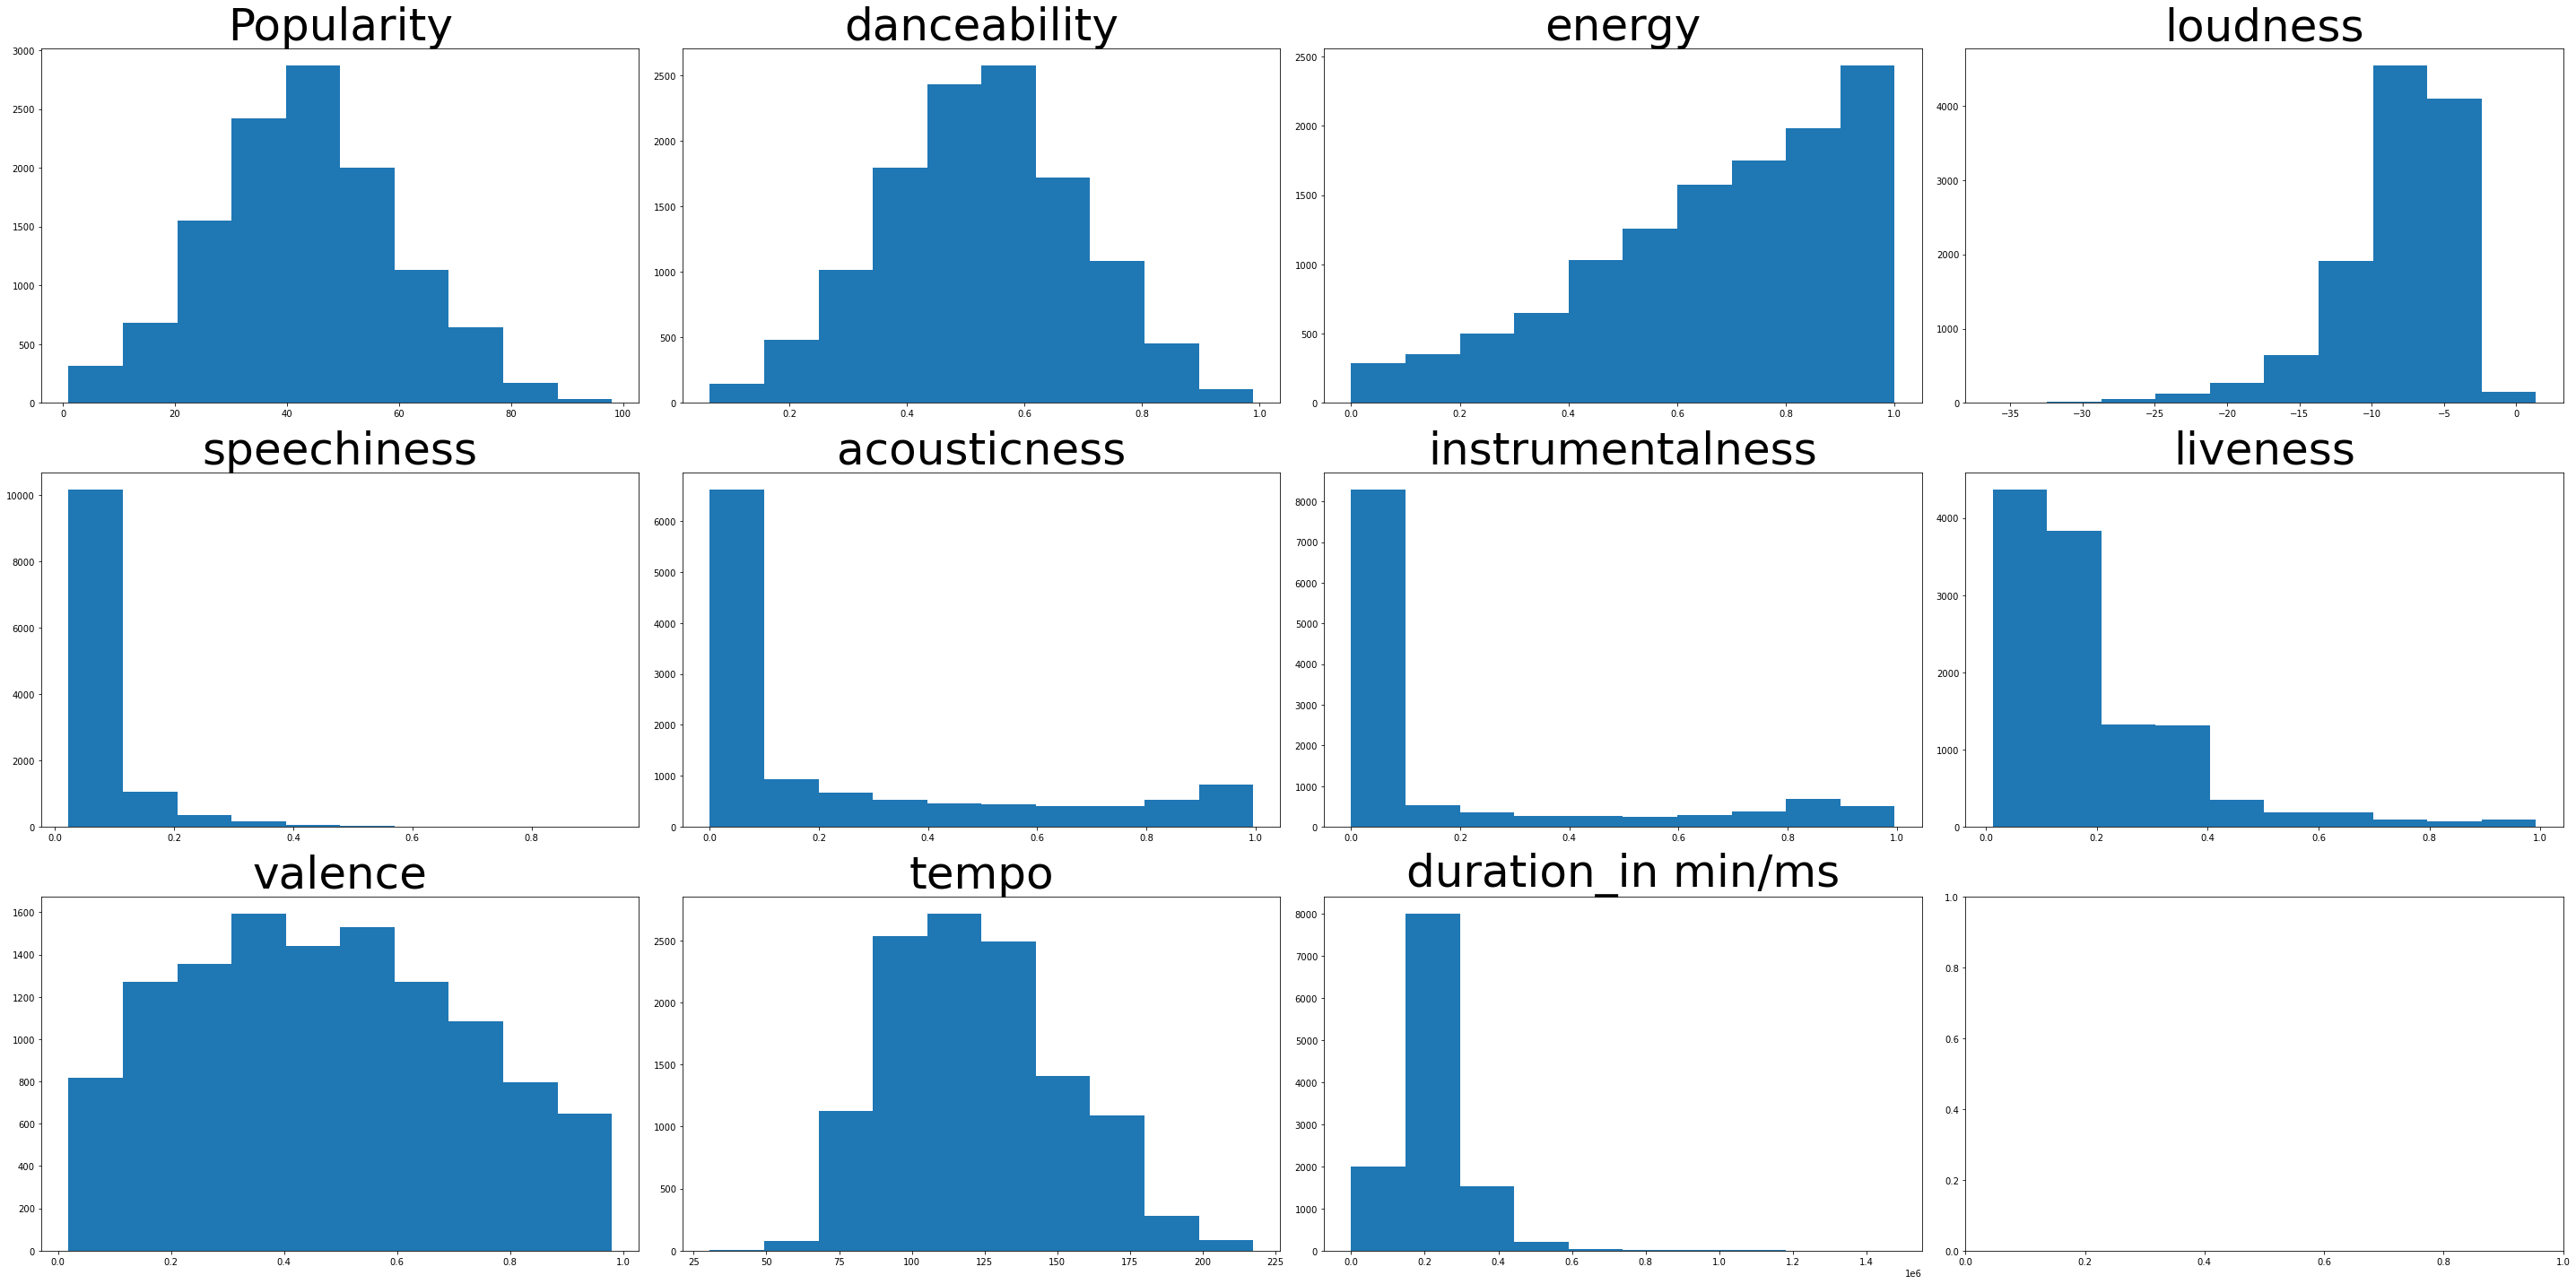

In [264]:
draw_histplot(data_without_na, num_features, 3, 4, 4)

Многие гистограммы смещены в одну из сторон, что свидетельствует о выбросах в наших данных. Посмотрим на эти данные с помощью box-plot.

In [265]:
def draw_boxplot(df, columns, nrows, ncols, n):
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(40, 20))

    # Создаем график для каждой колонки
    for i, column in enumerate(columns):
        row = i // n
        col = i % n
        axes[row, col].boxplot(df[column])
        axes[row, col].set_title(column, size=50)

    # Отображаем графики
    plt.tight_layout()
    plt.show()

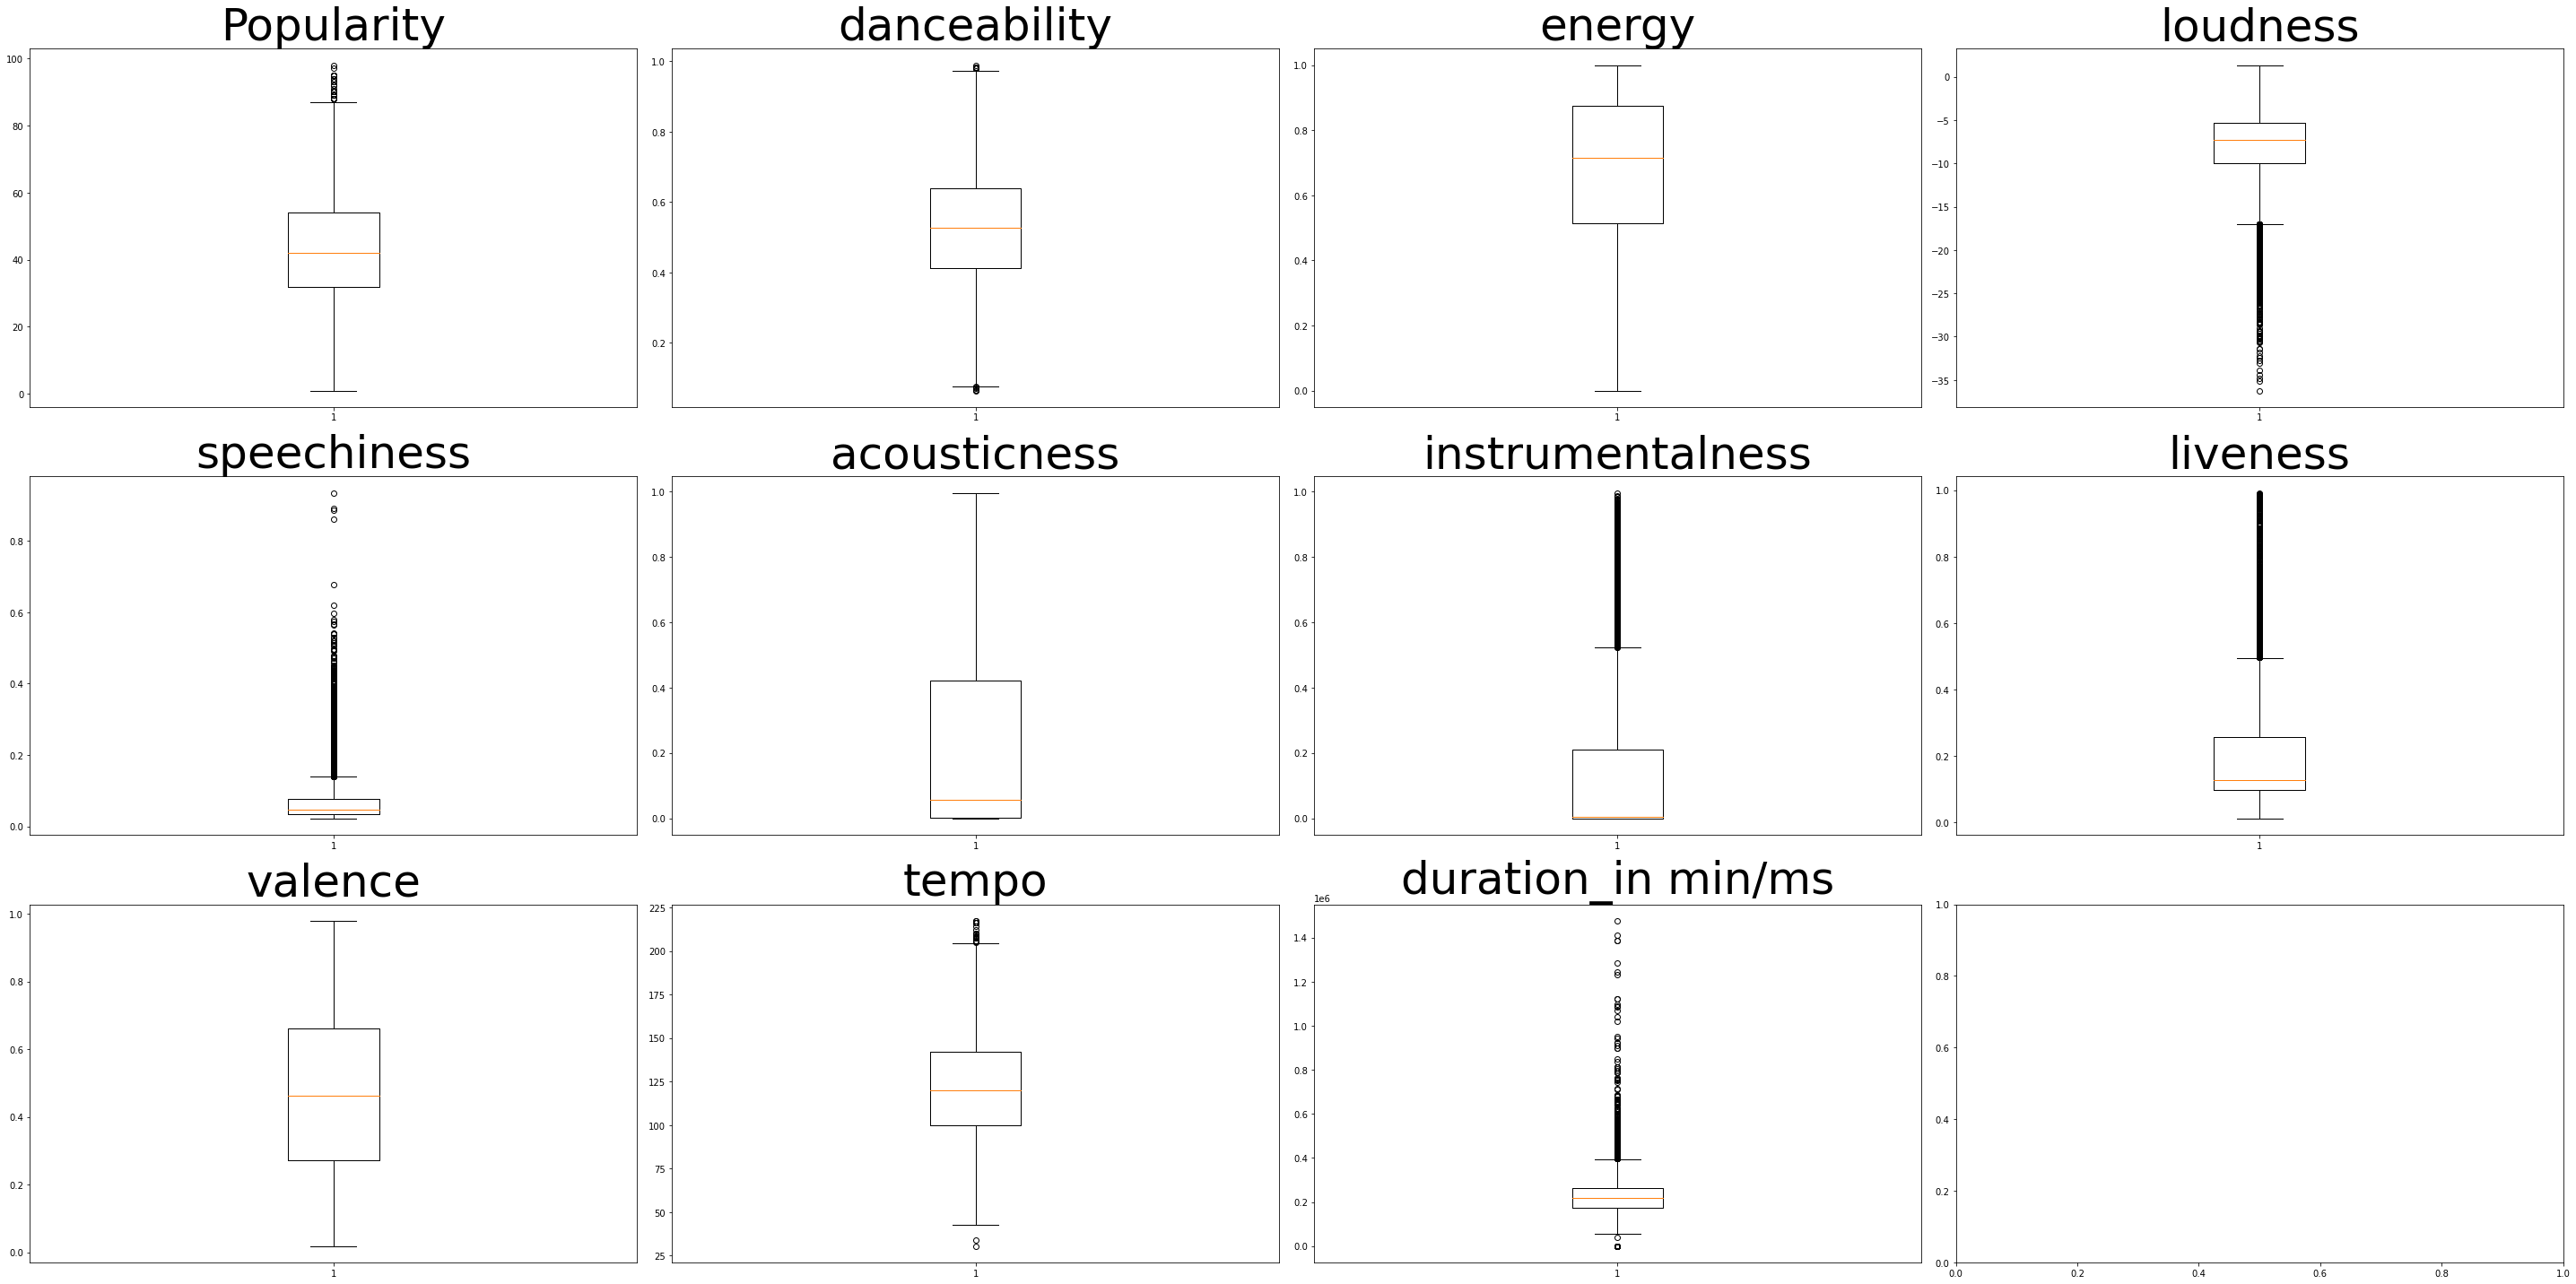

In [266]:
draw_boxplot(data_without_na, num_features, 3, 4, 4)

Теперь поработаем с выбросами:

In [267]:
def remove_outliers(data, columns, threshold=3):
    data_no_outliers = data.copy()
    
    for col in columns:
        mean = data_no_outliers[col].mean()
        std = data_no_outliers[col].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        data_no_outliers = data_no_outliers[(data_no_outliers[col] >= lower_bound) & (data_no_outliers[col] <= upper_bound)]
    
    return data_no_outliers

filtered_data = remove_outliers(data_without_na, num_features)

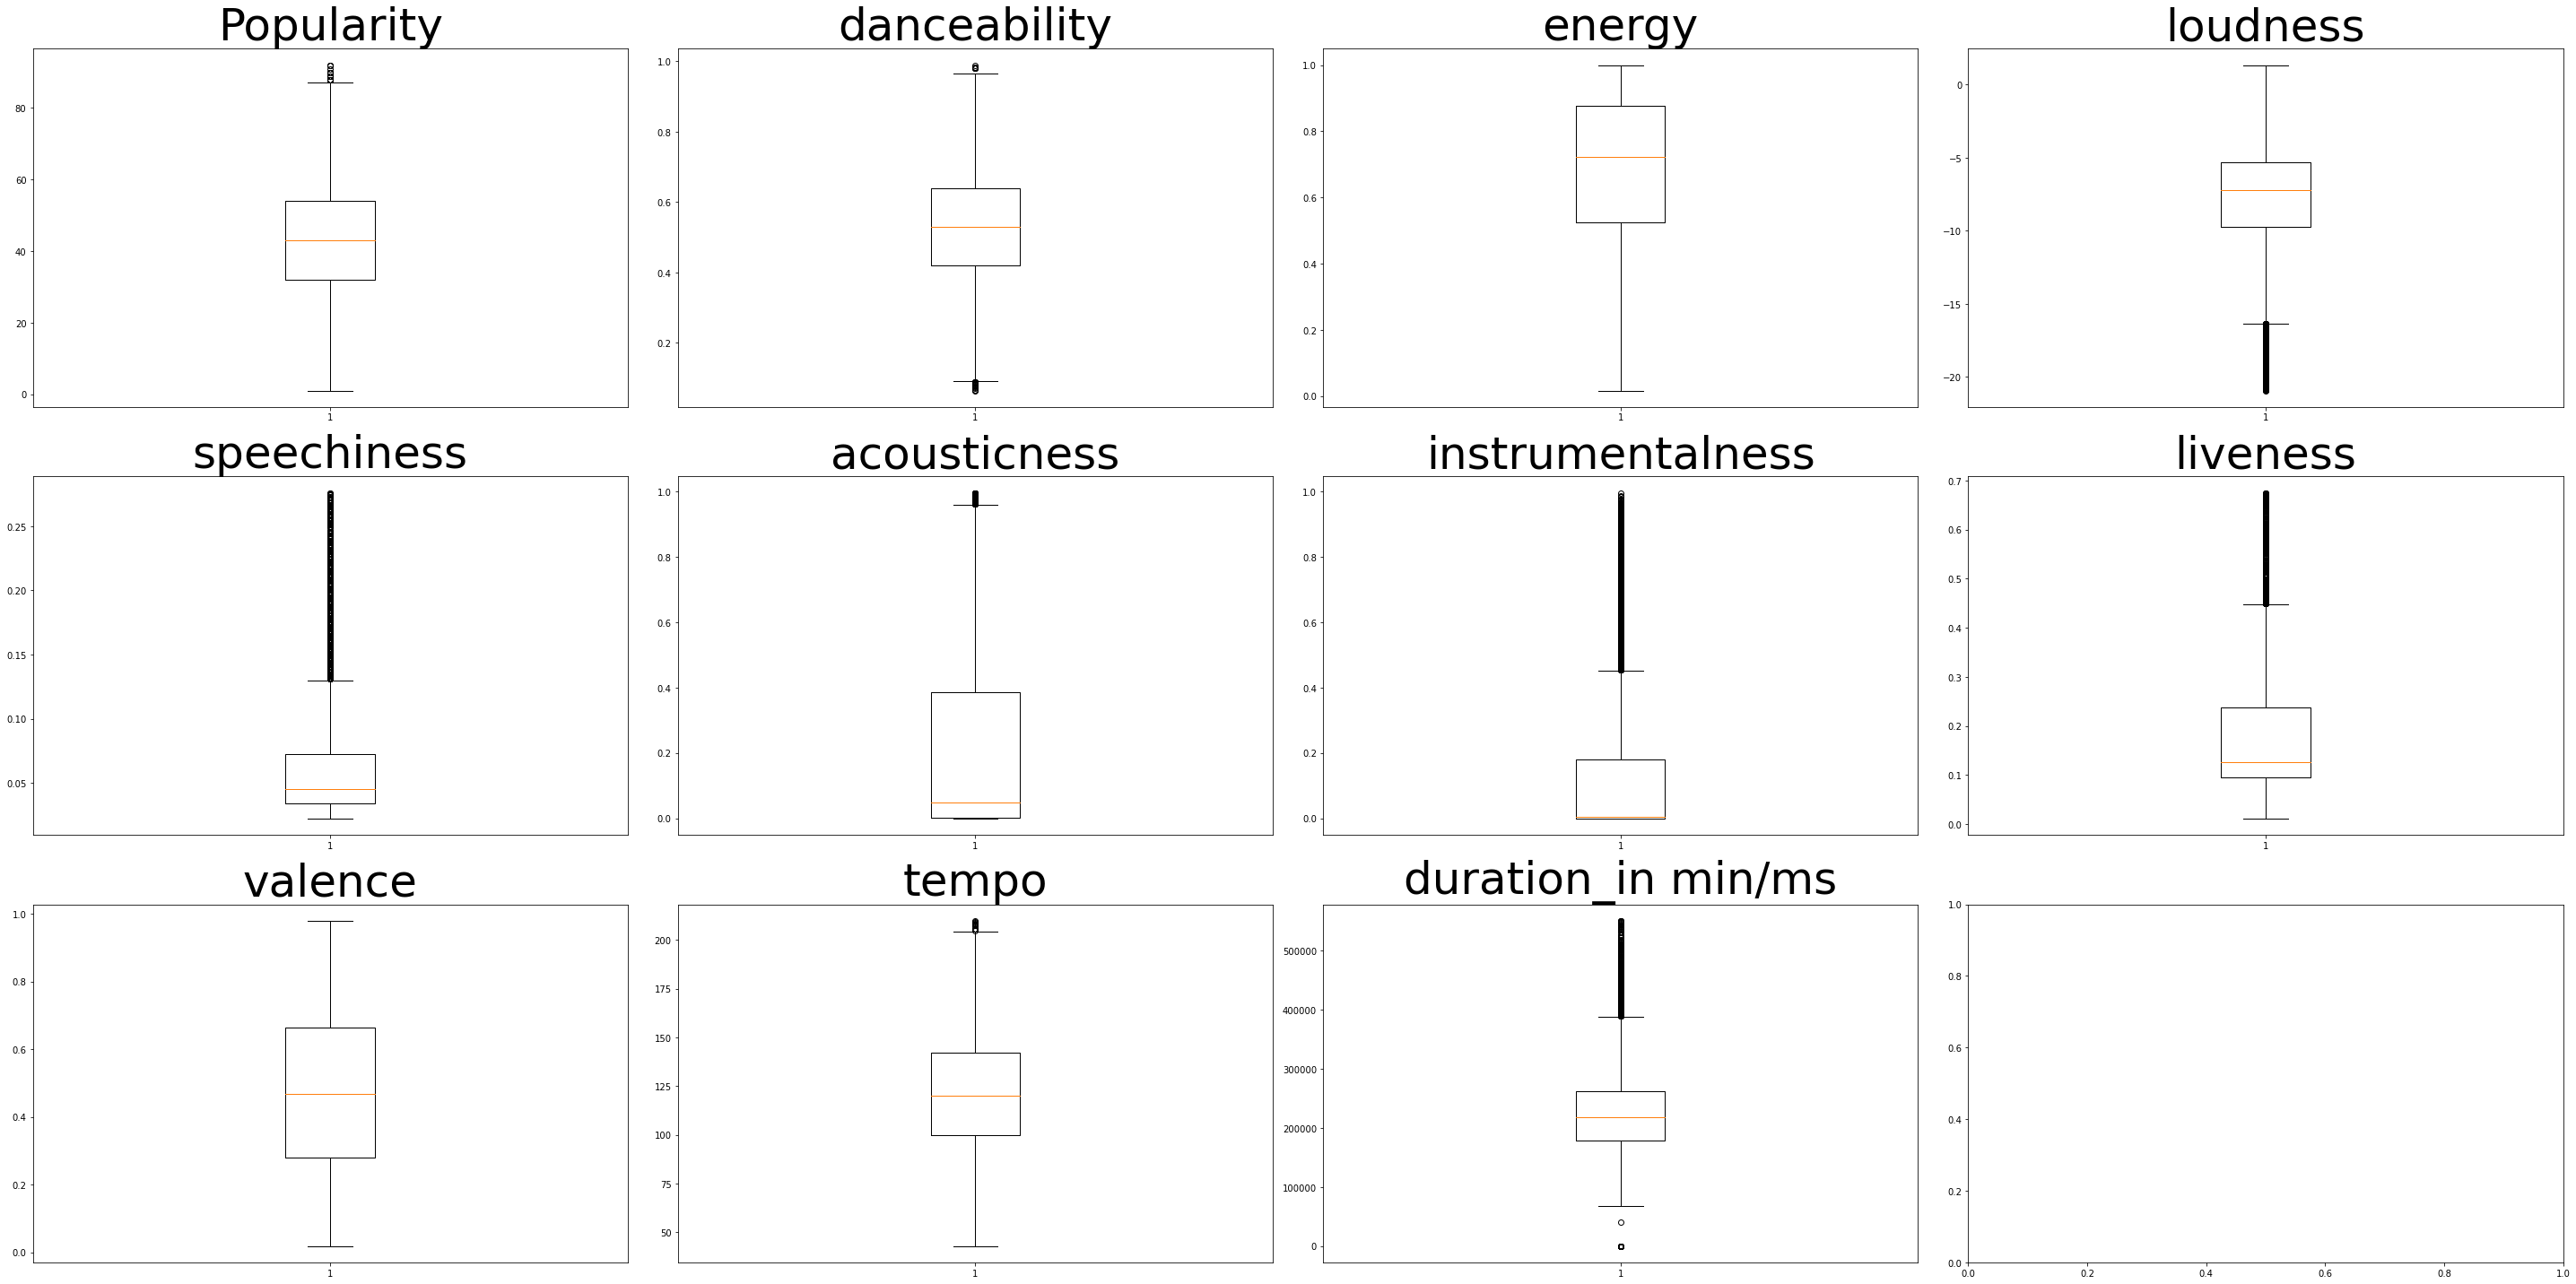

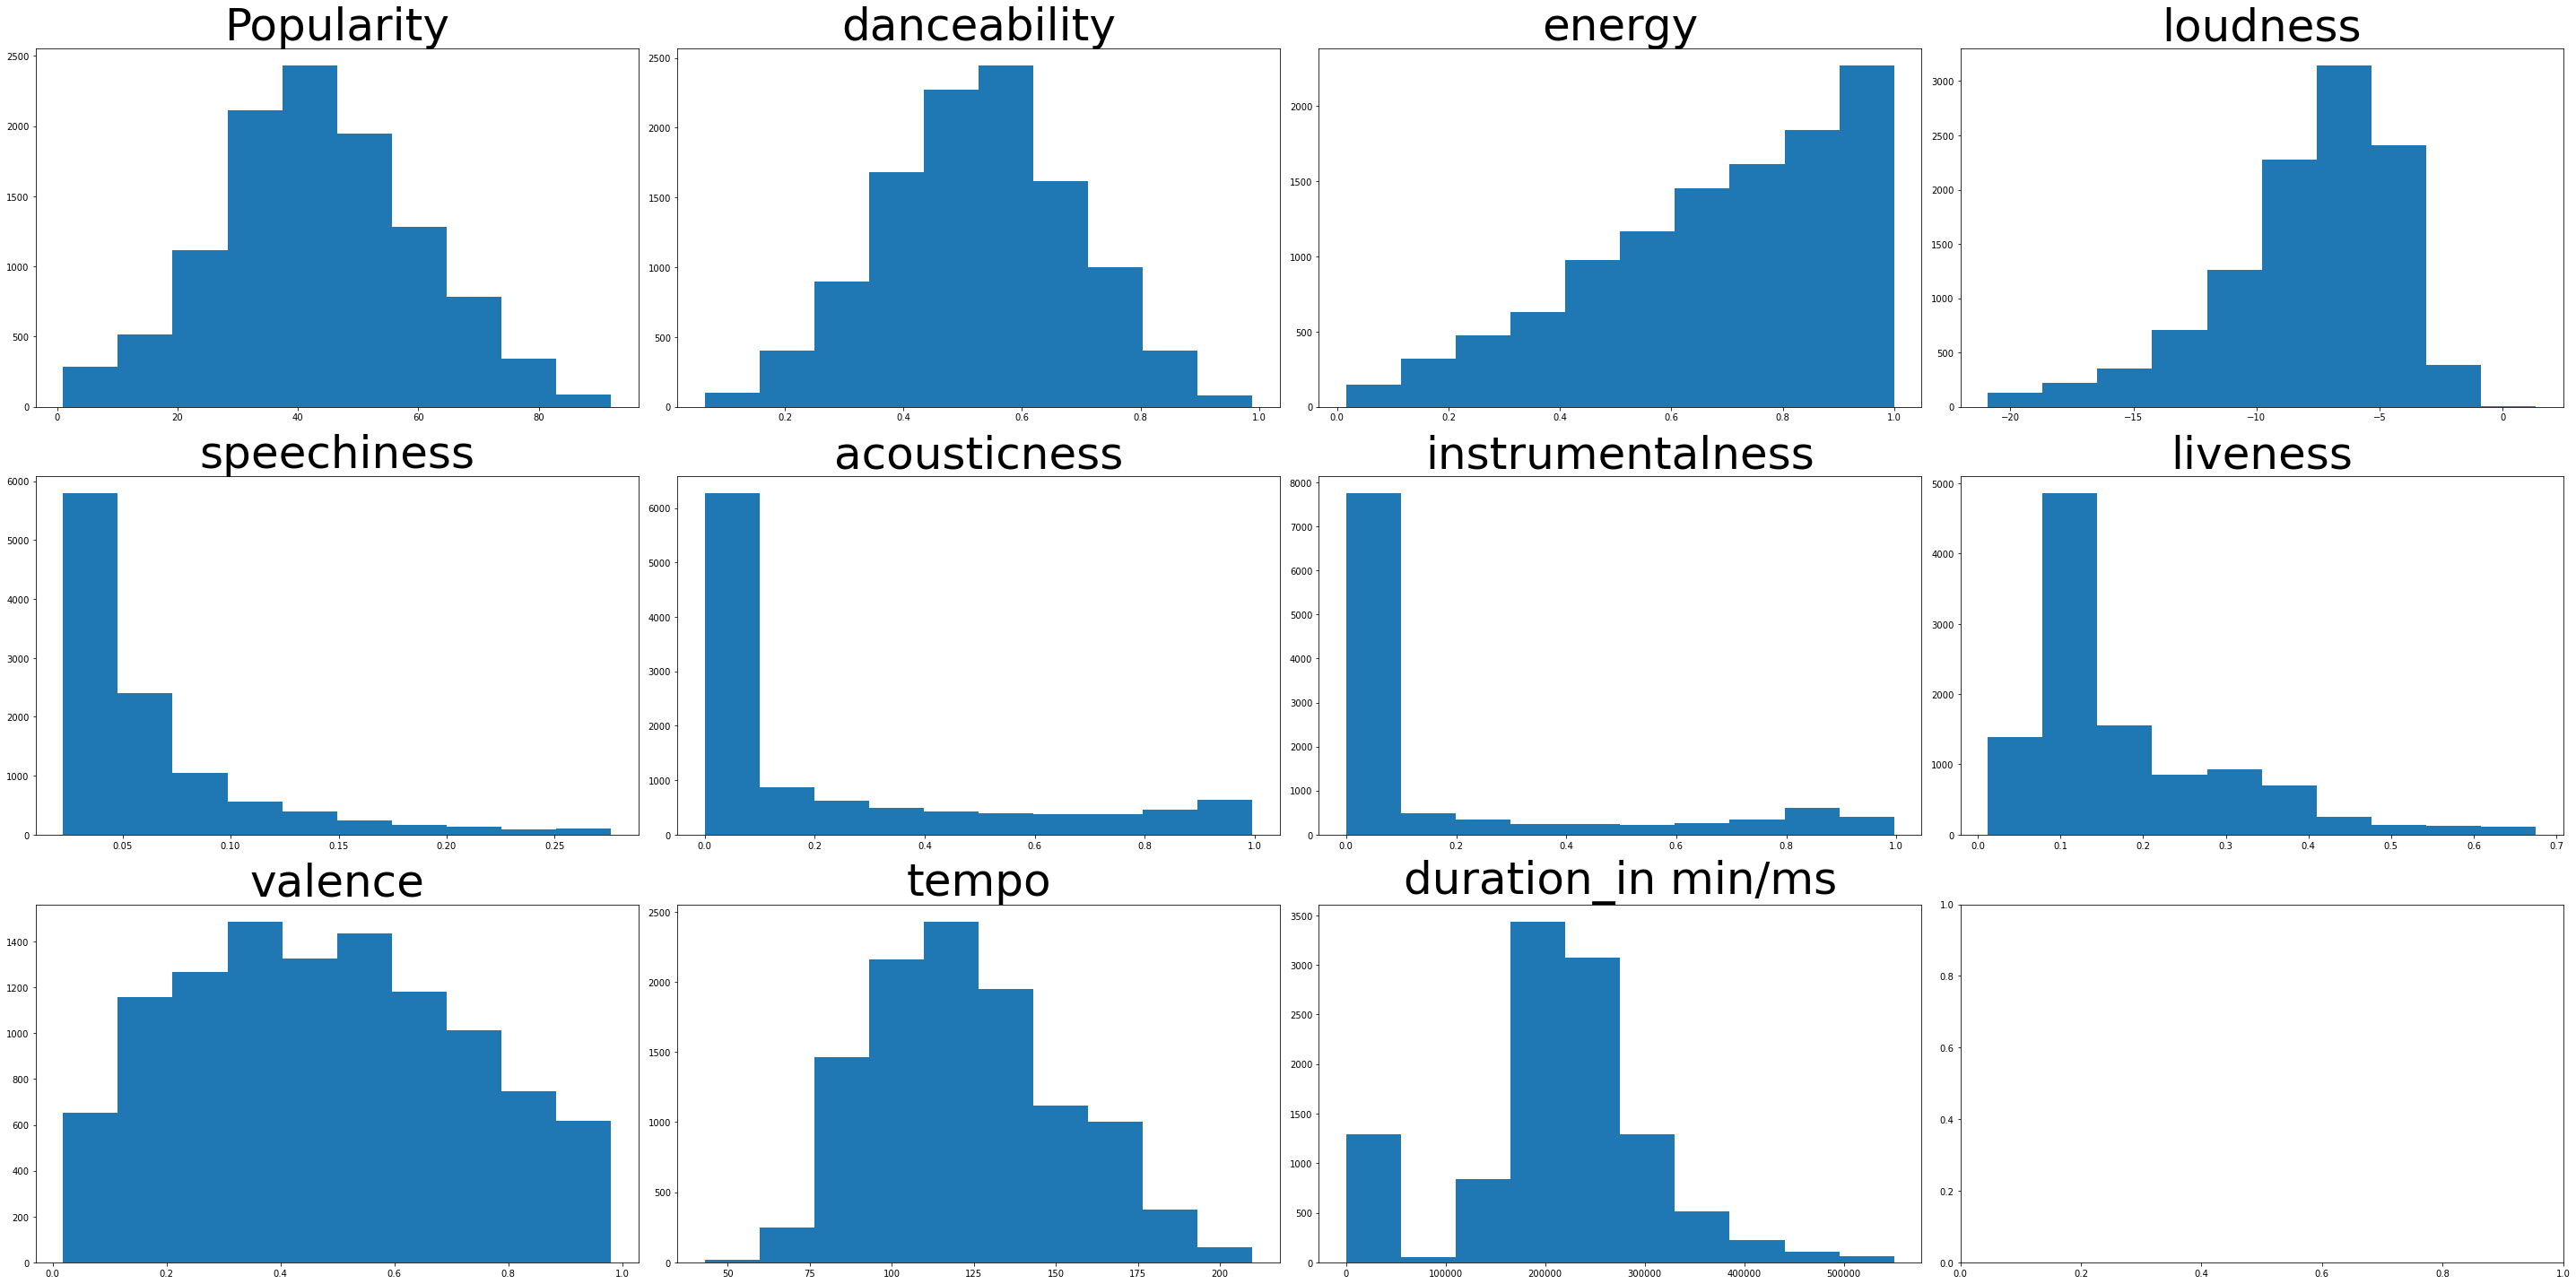

In [268]:
draw_boxplot(filtered_data, num_features, 3, 4, 4), draw_histplot(filtered_data, num_features, 3, 4, 4);

Отбросили самые явные и наиболее сильно выбивающиеся выбросы, утсновив трешхолд равный 3. 

Теперь оценим баланс классов в датасете без NA и в отфильтрованном датасете. 

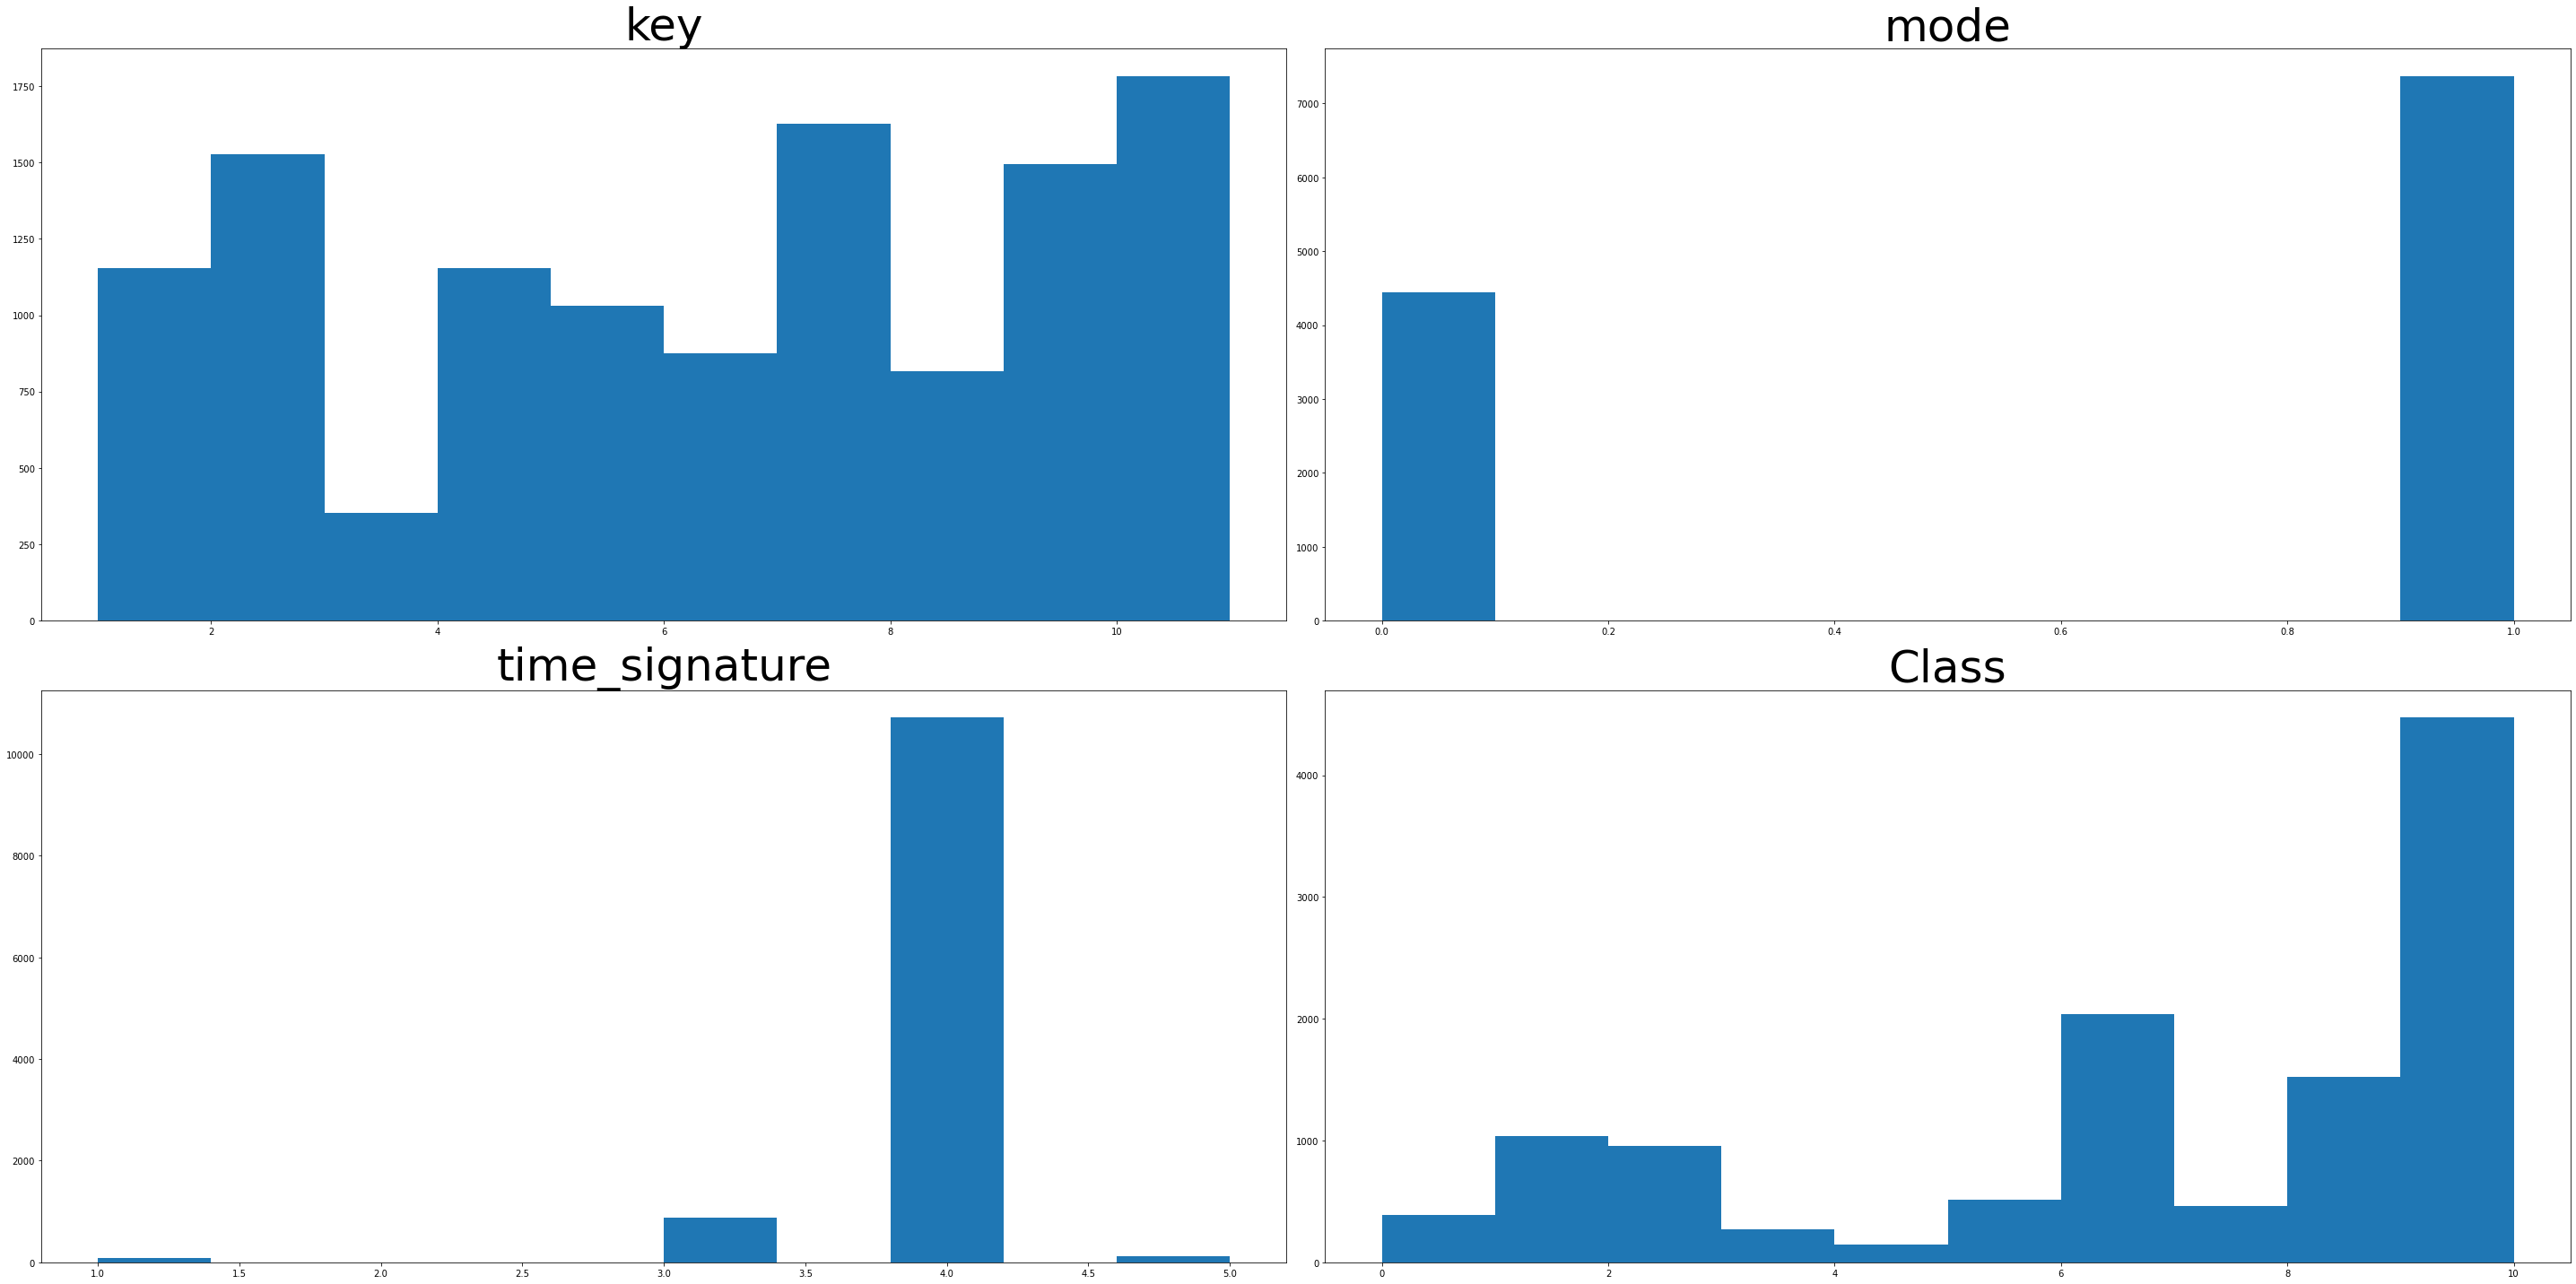

In [269]:
draw_histplot(data_without_na, cat_features, 2, 2, 2)

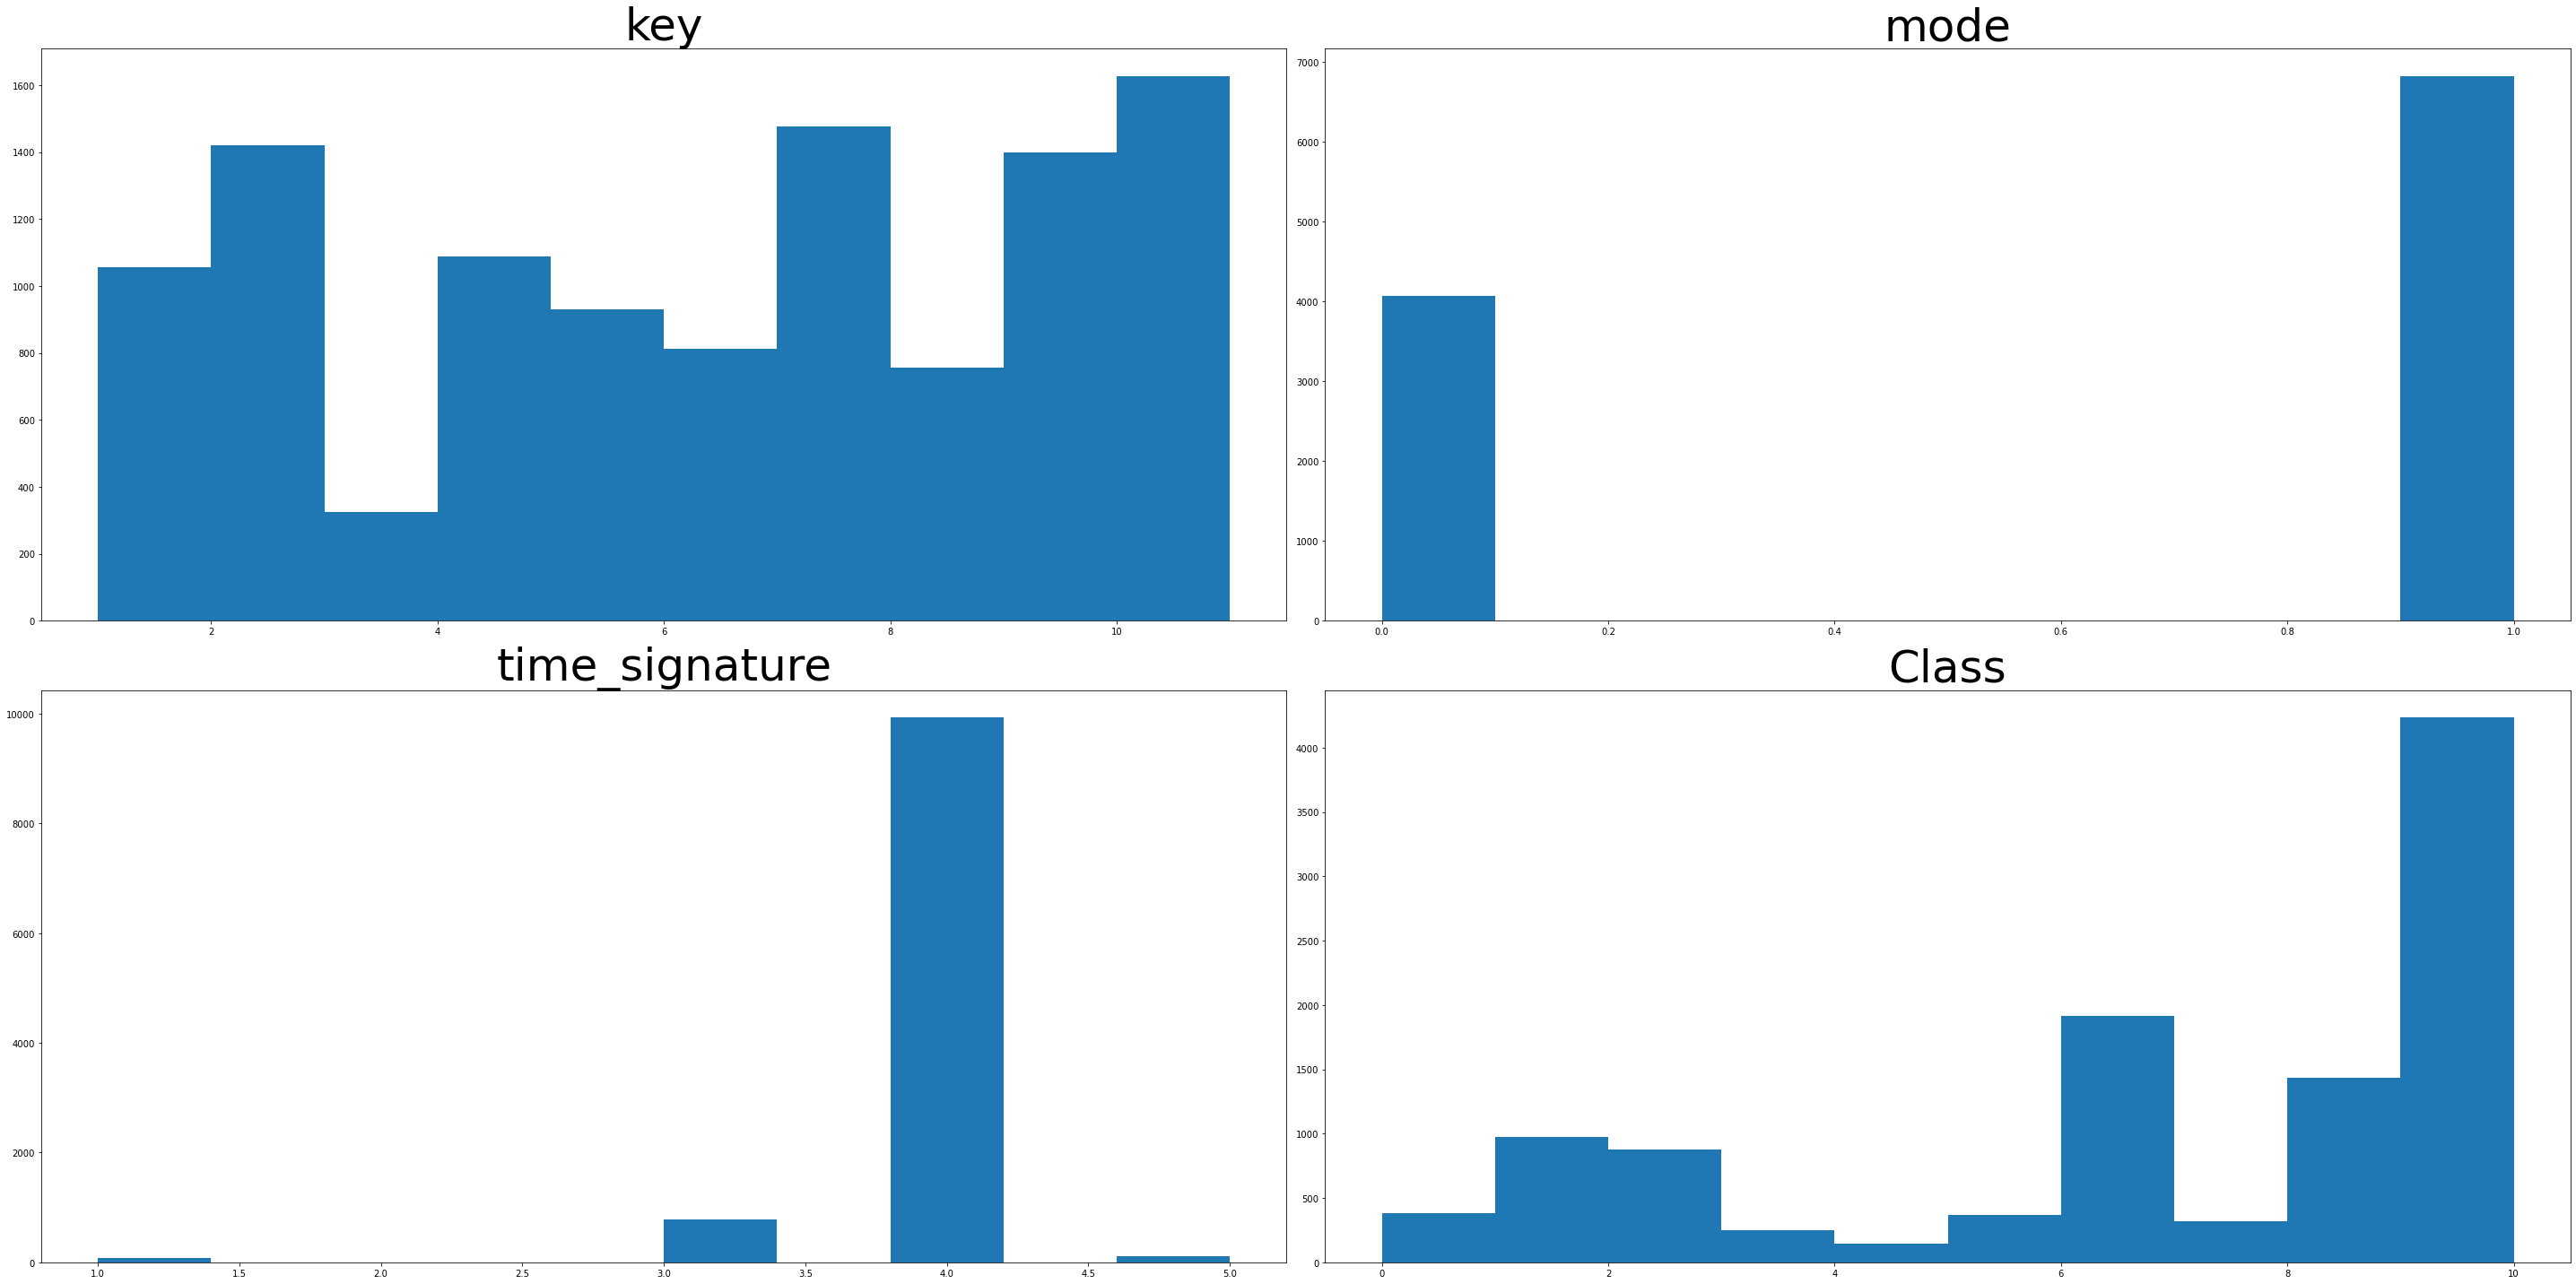

In [270]:
draw_histplot(filtered_data, cat_features, 2, 2, 2)

По полученным графикам мы можем устновить, что в классе `time_signature` серьезный дисбаланс классов. Эту проблему можно решить, к примеру, введением весов классам. 

Теперь рассмотрим второй вариант, в котором мы заменим пропущенные значения в числовых переменных на среднее, а в категориальных заменим на моду. 

In [271]:
data[num_features] = data[num_features].fillna(data[num_features].mean())
data[cat_features] = data[cat_features].fillna(data[cat_features].mode().iloc[0])

In [272]:
columns = cat_features + num_features
data_new = data[columns]

Теперь посмотрим на распределения данных и на выбросы

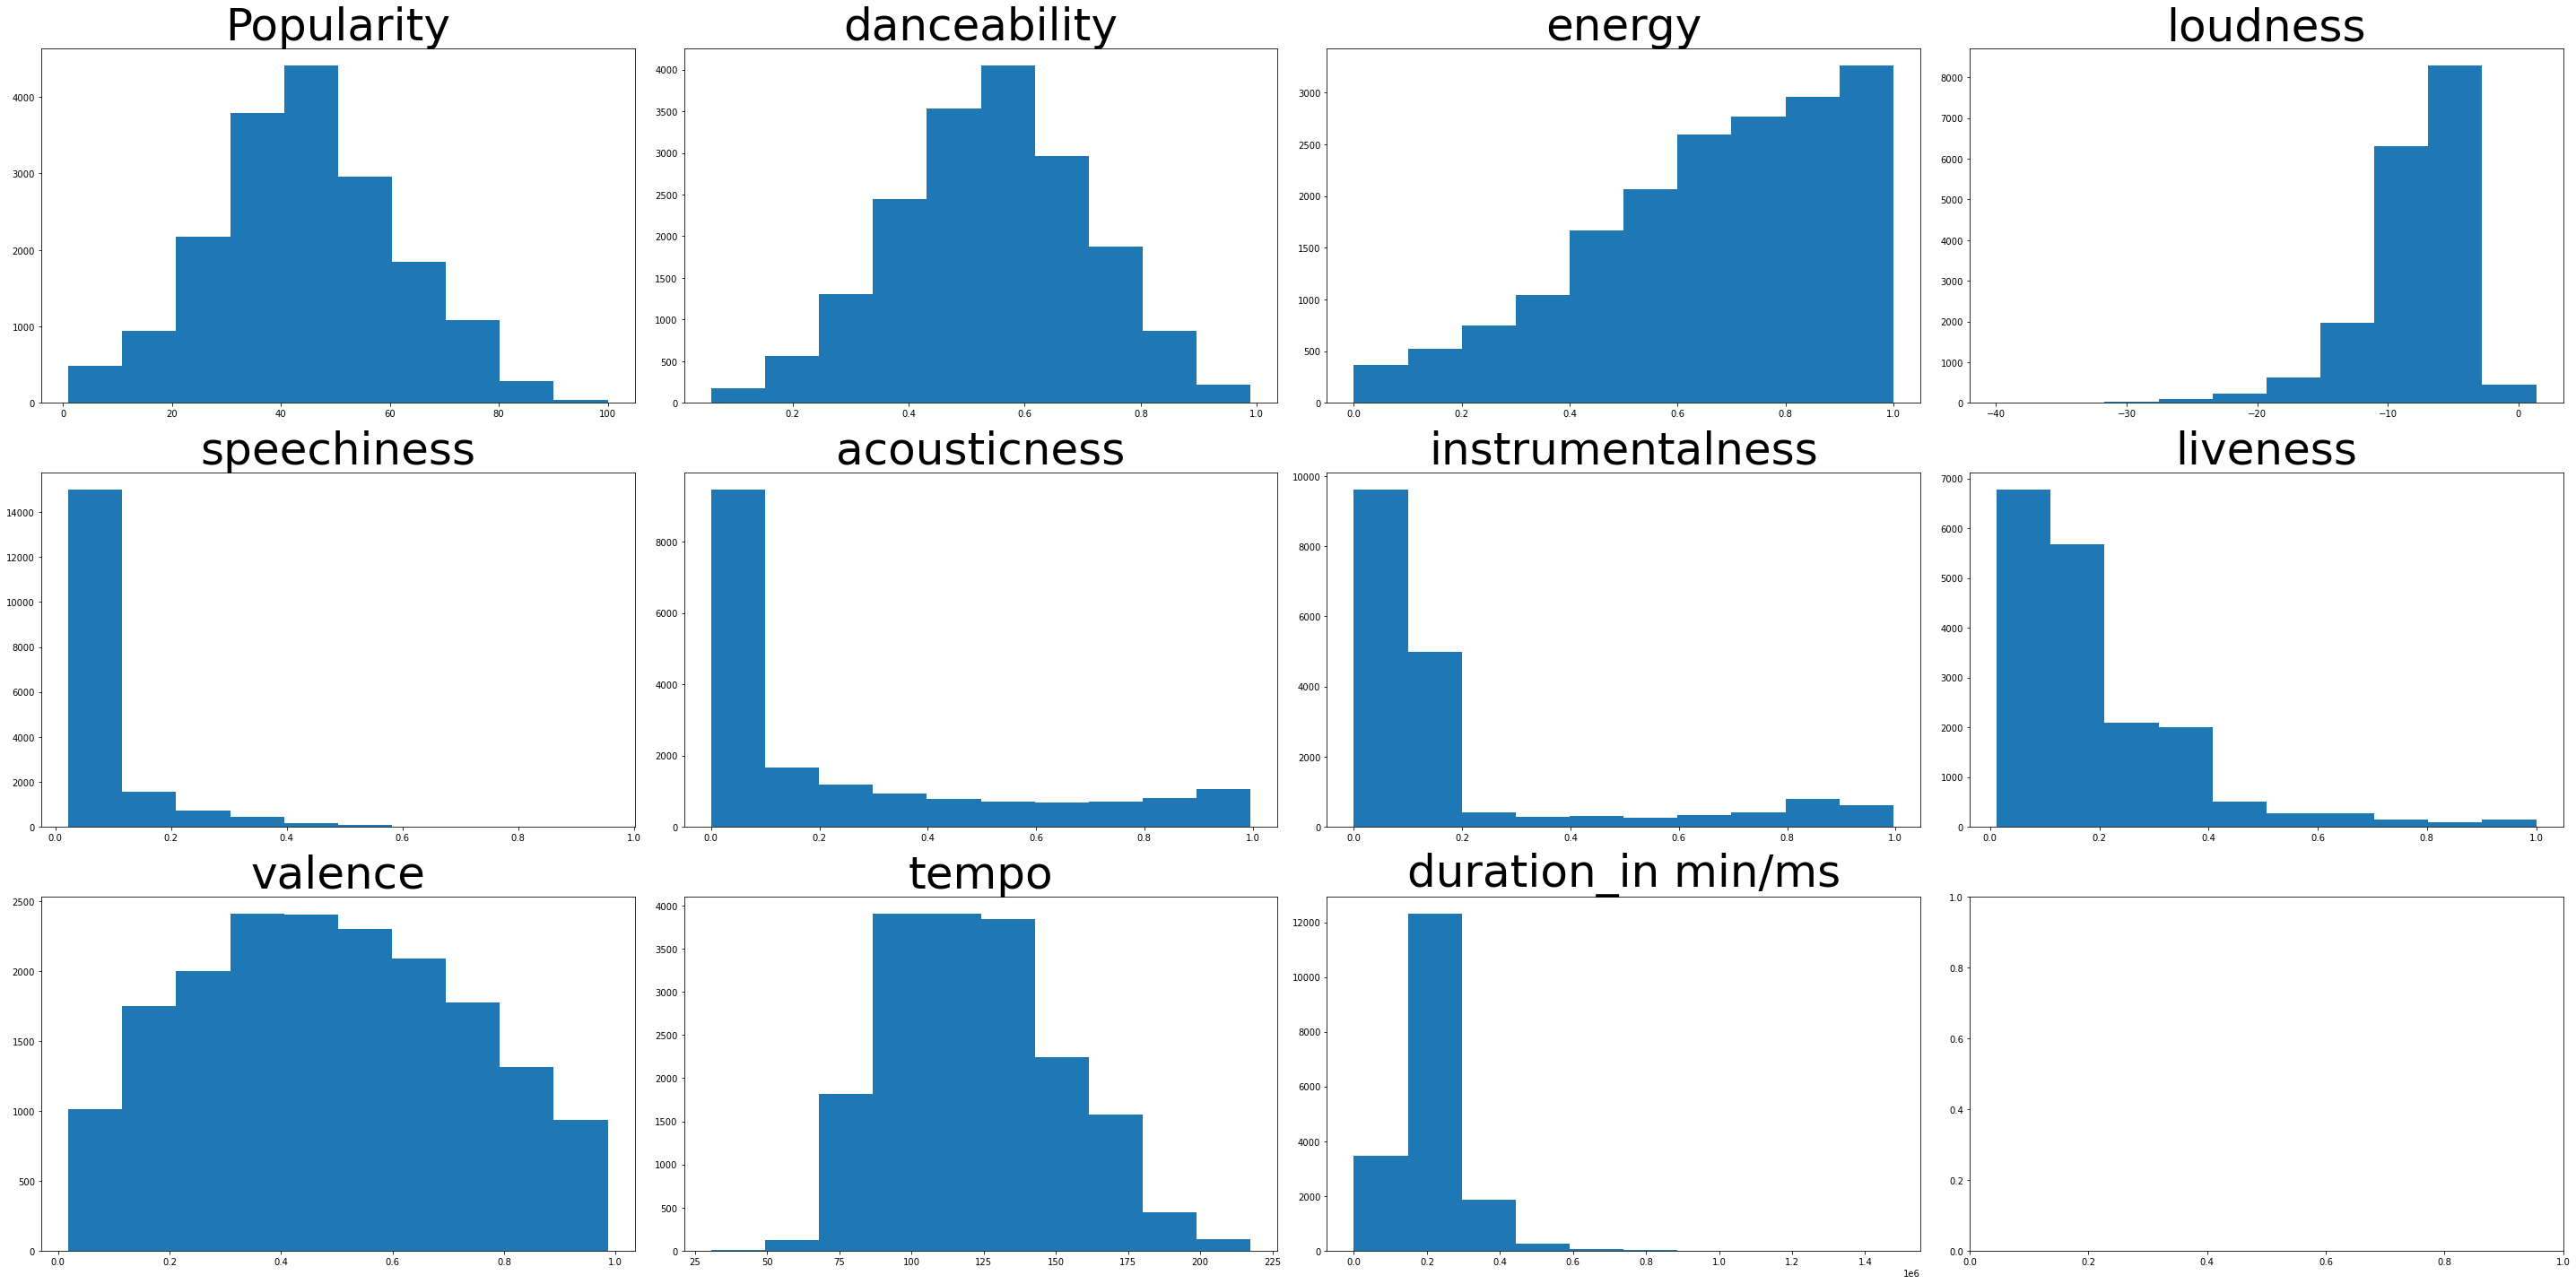

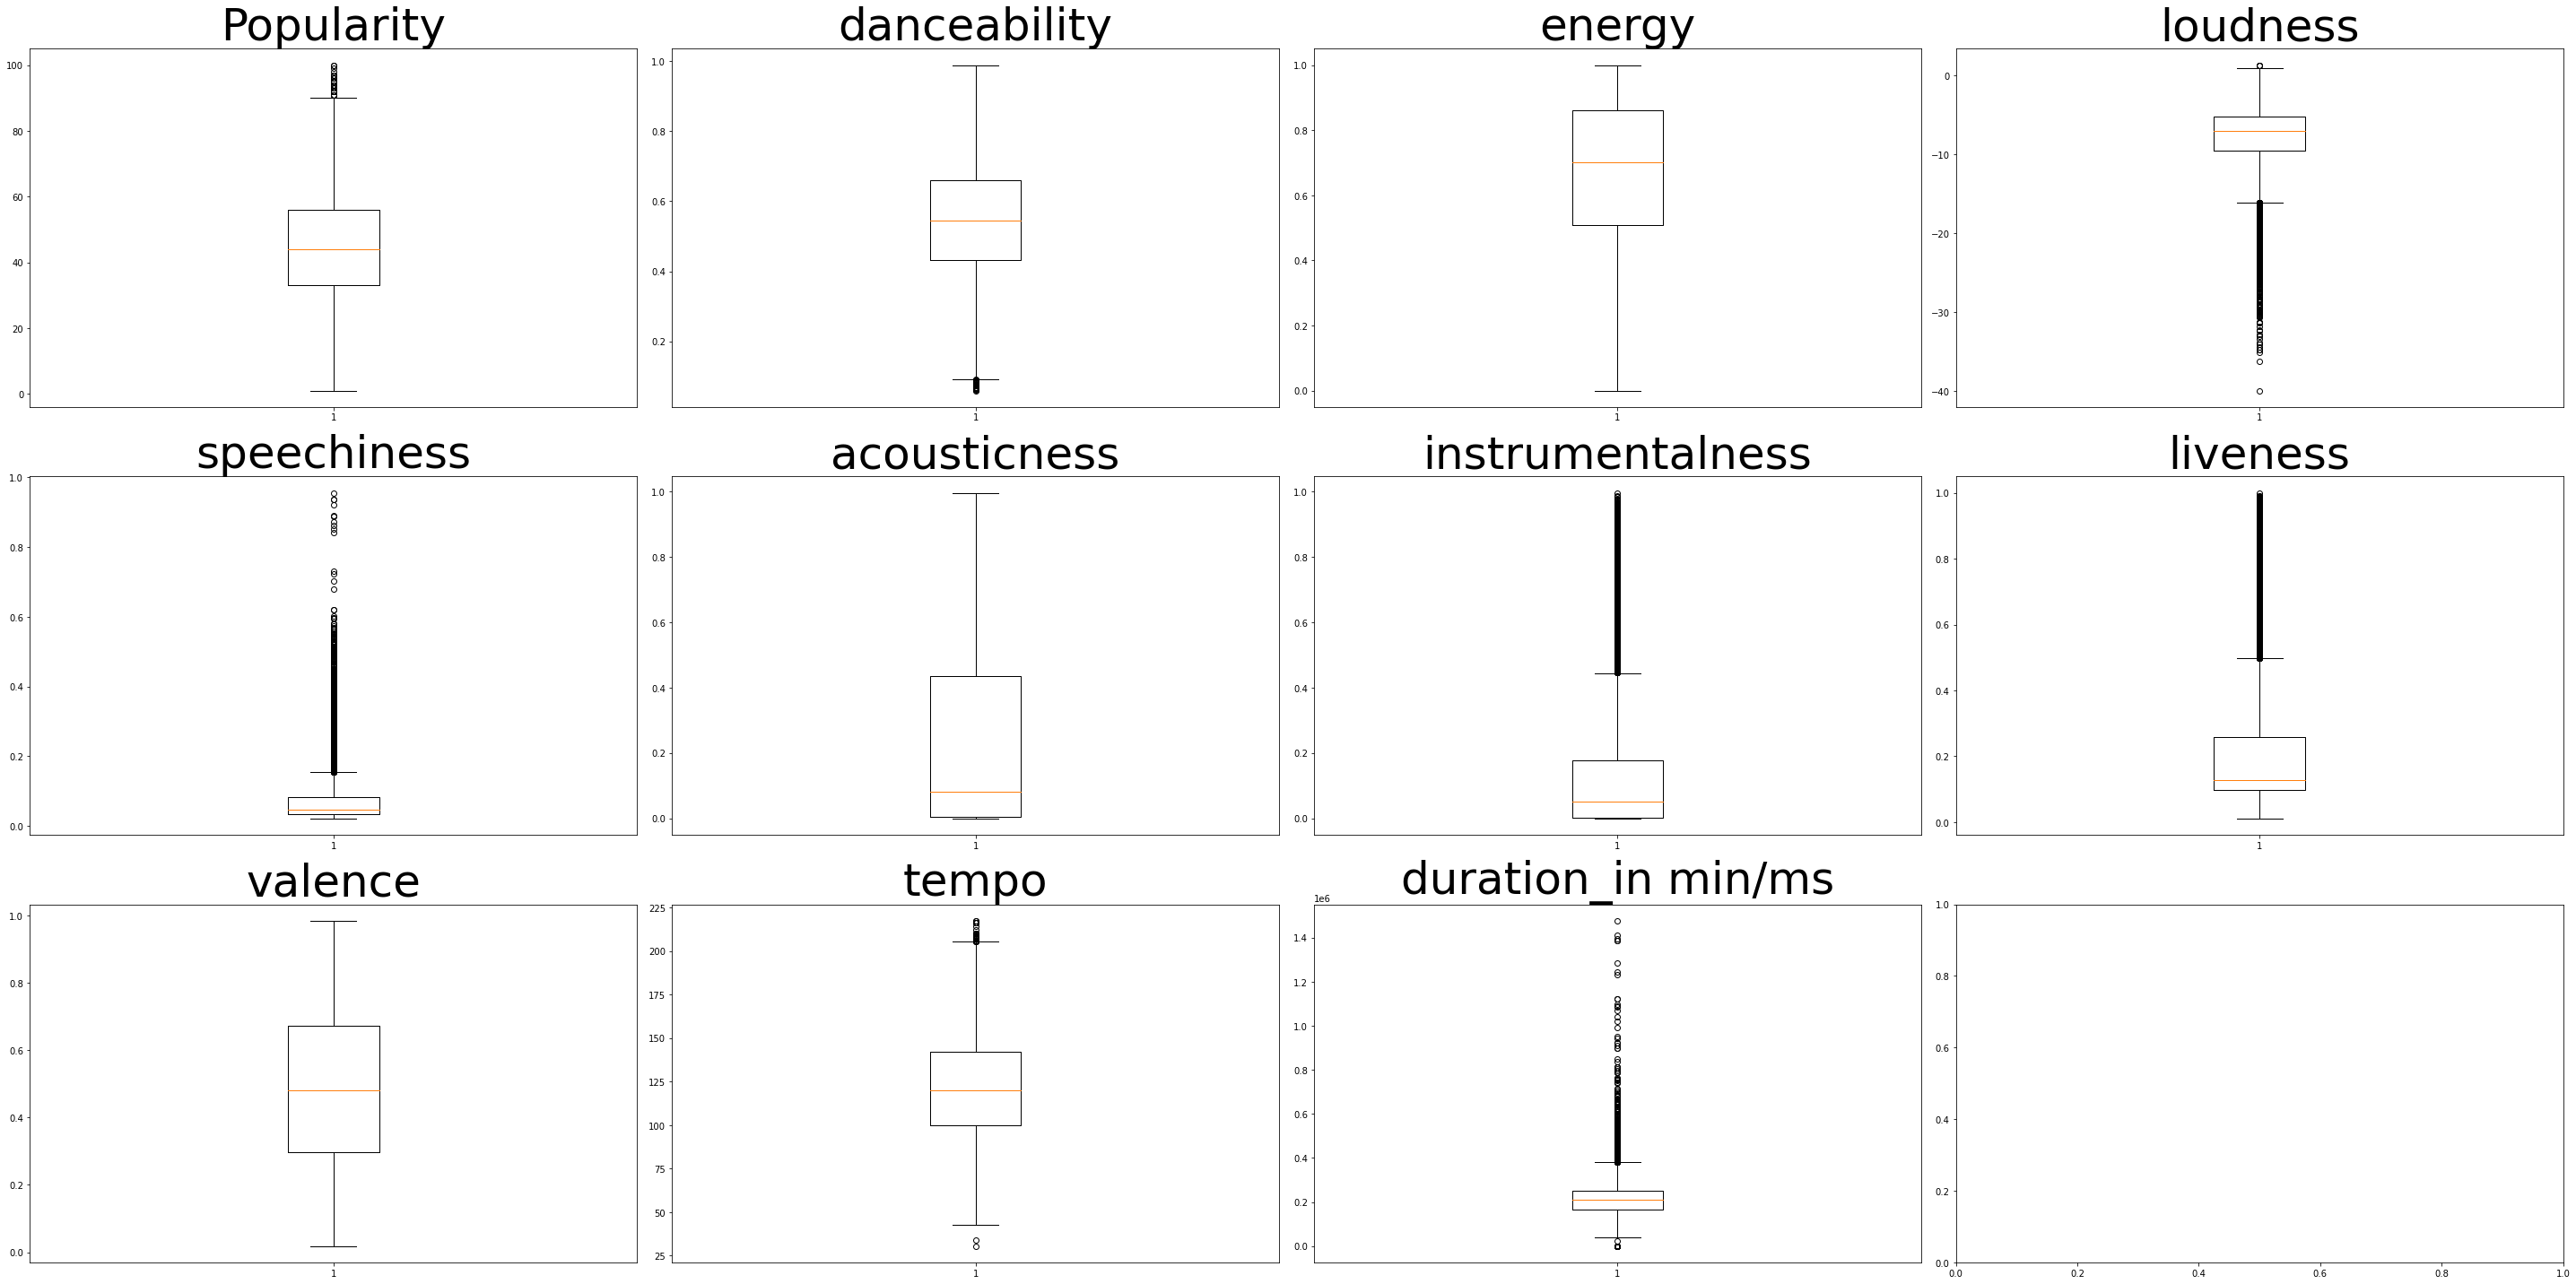

In [273]:
draw_histplot(data_new, num_features, 3, 4, 4), draw_boxplot(data_new, num_features, 3, 4, 4);

Наблюдаем похожую ситуацию, как и в первом случае. Поэтому поработаем с выбросами. 

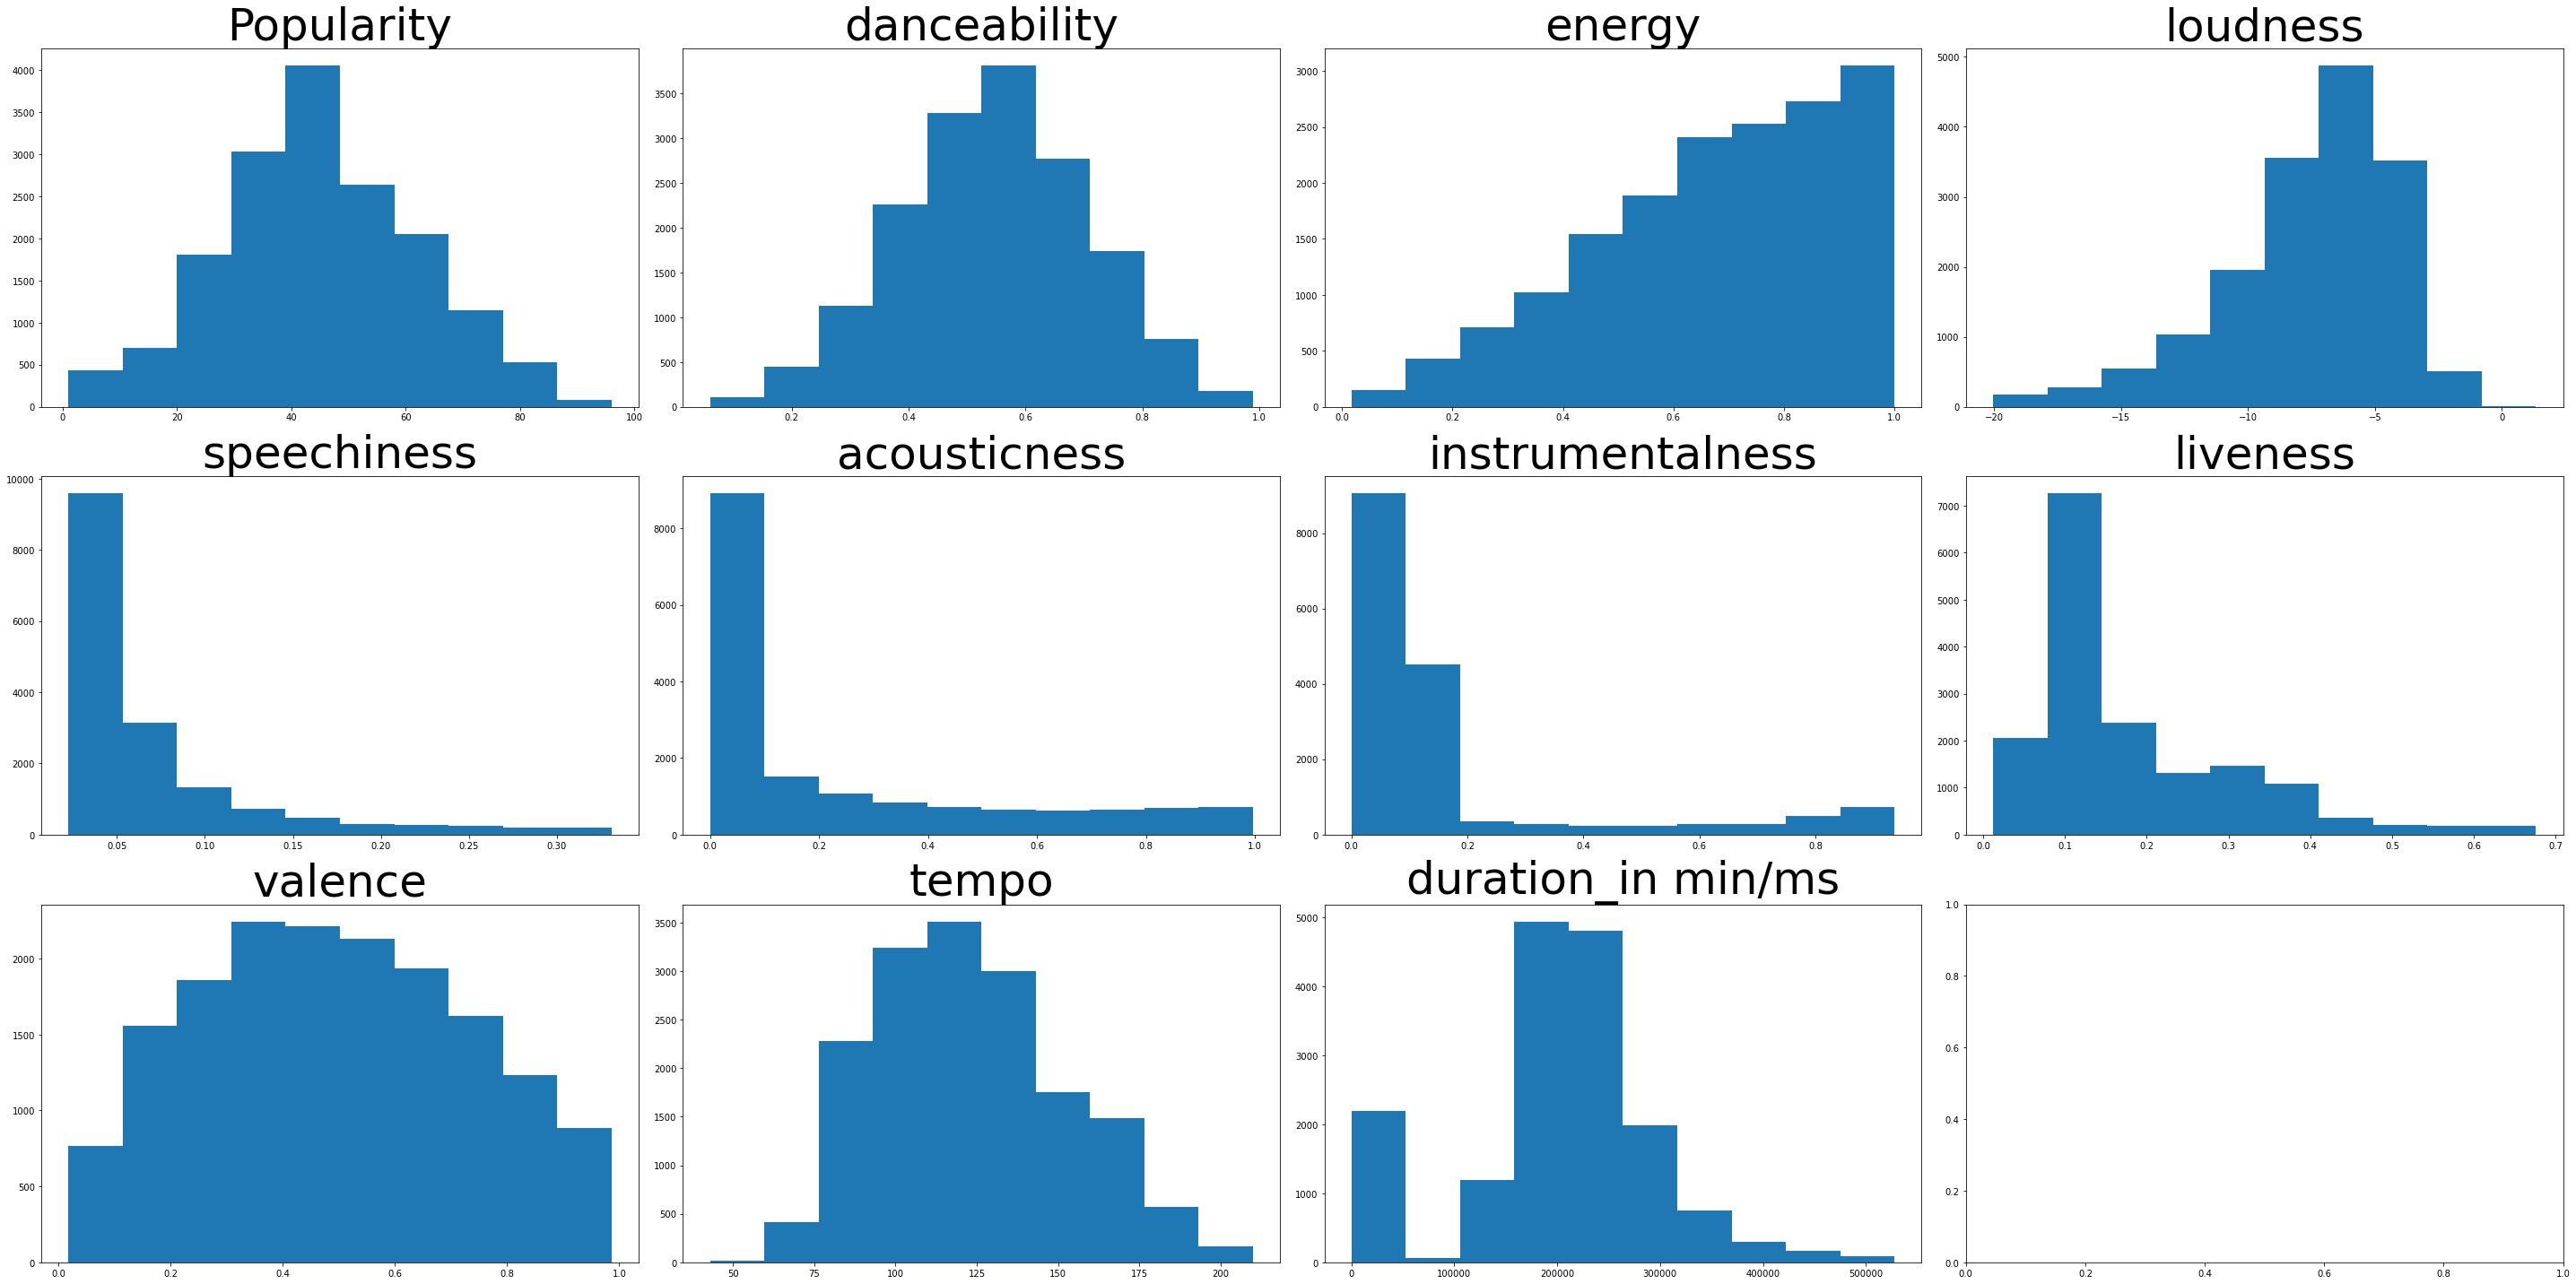

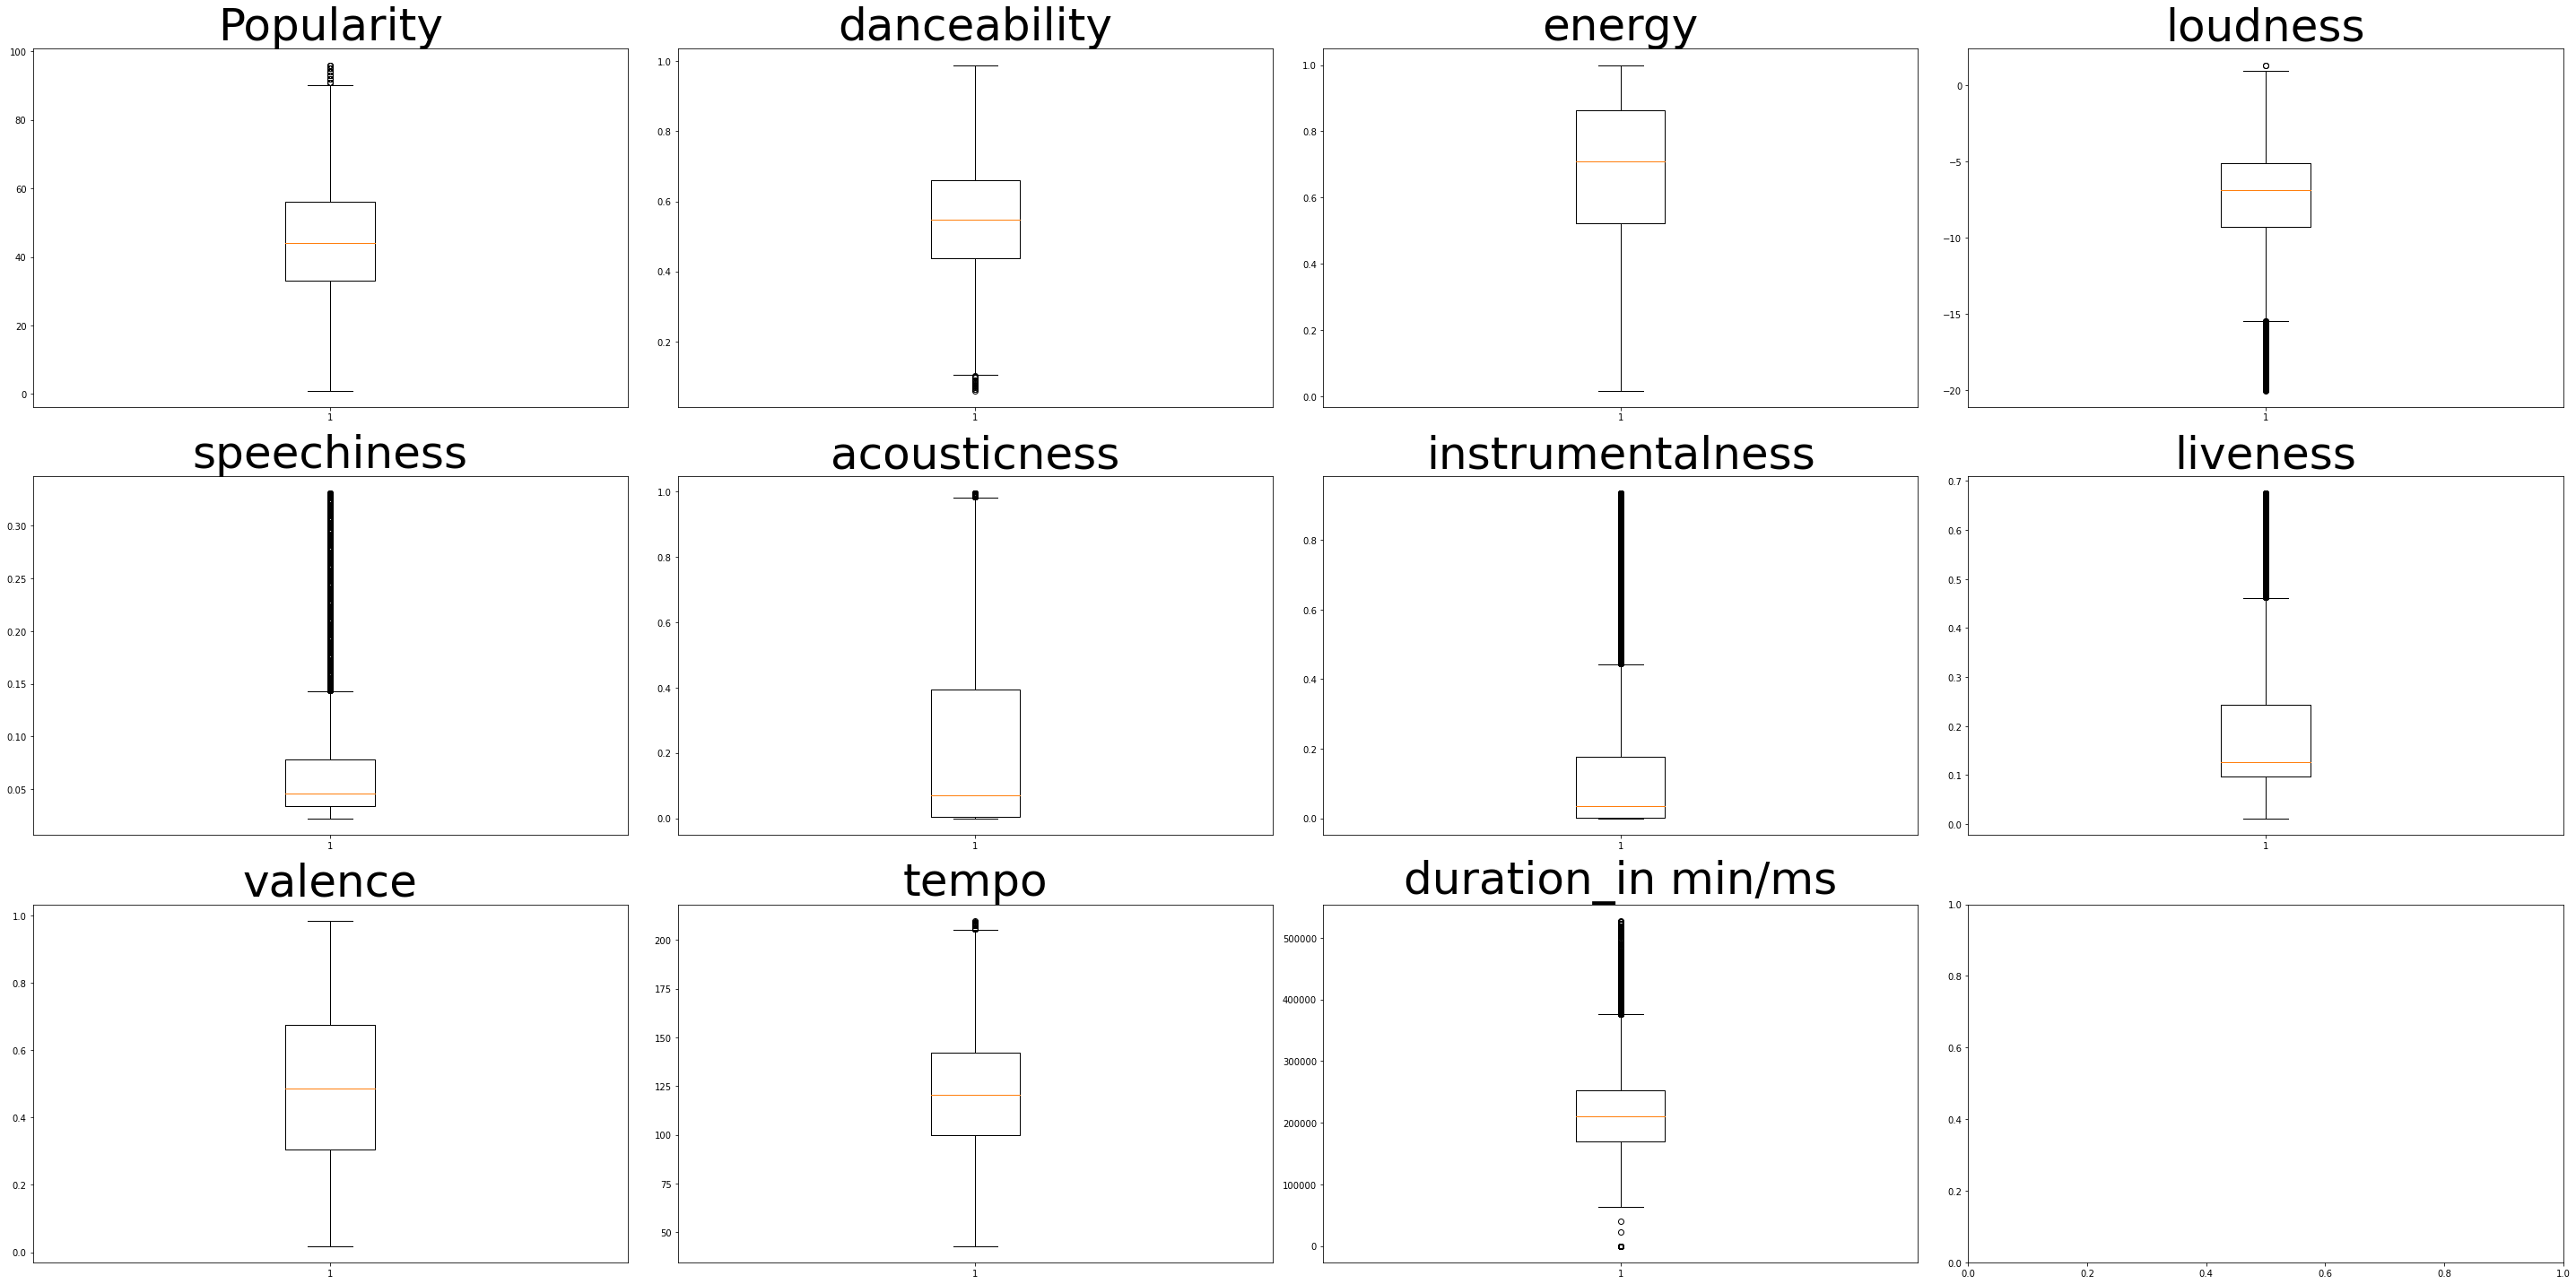

In [274]:
filtered_data_new = remove_outliers(data_new, num_features)
draw_histplot(filtered_data_new, num_features, 3, 4, 4), draw_boxplot(filtered_data_new, num_features, 3, 4, 4);

Не вижу никаких серьезных различий между двумя подходами в плане отображенмя данных или же количества выбросов, единственное, что во втором случае случае наблюдений больше на ~6000. Что конечно же располагает нас в сторону выбора 2 пути. 

Но мне кажется тут можно чуть пожертвовать количеством данных и постараться максимально убрать выбросы, поэтому дальше я постараюсь найти оптимальный threshold.

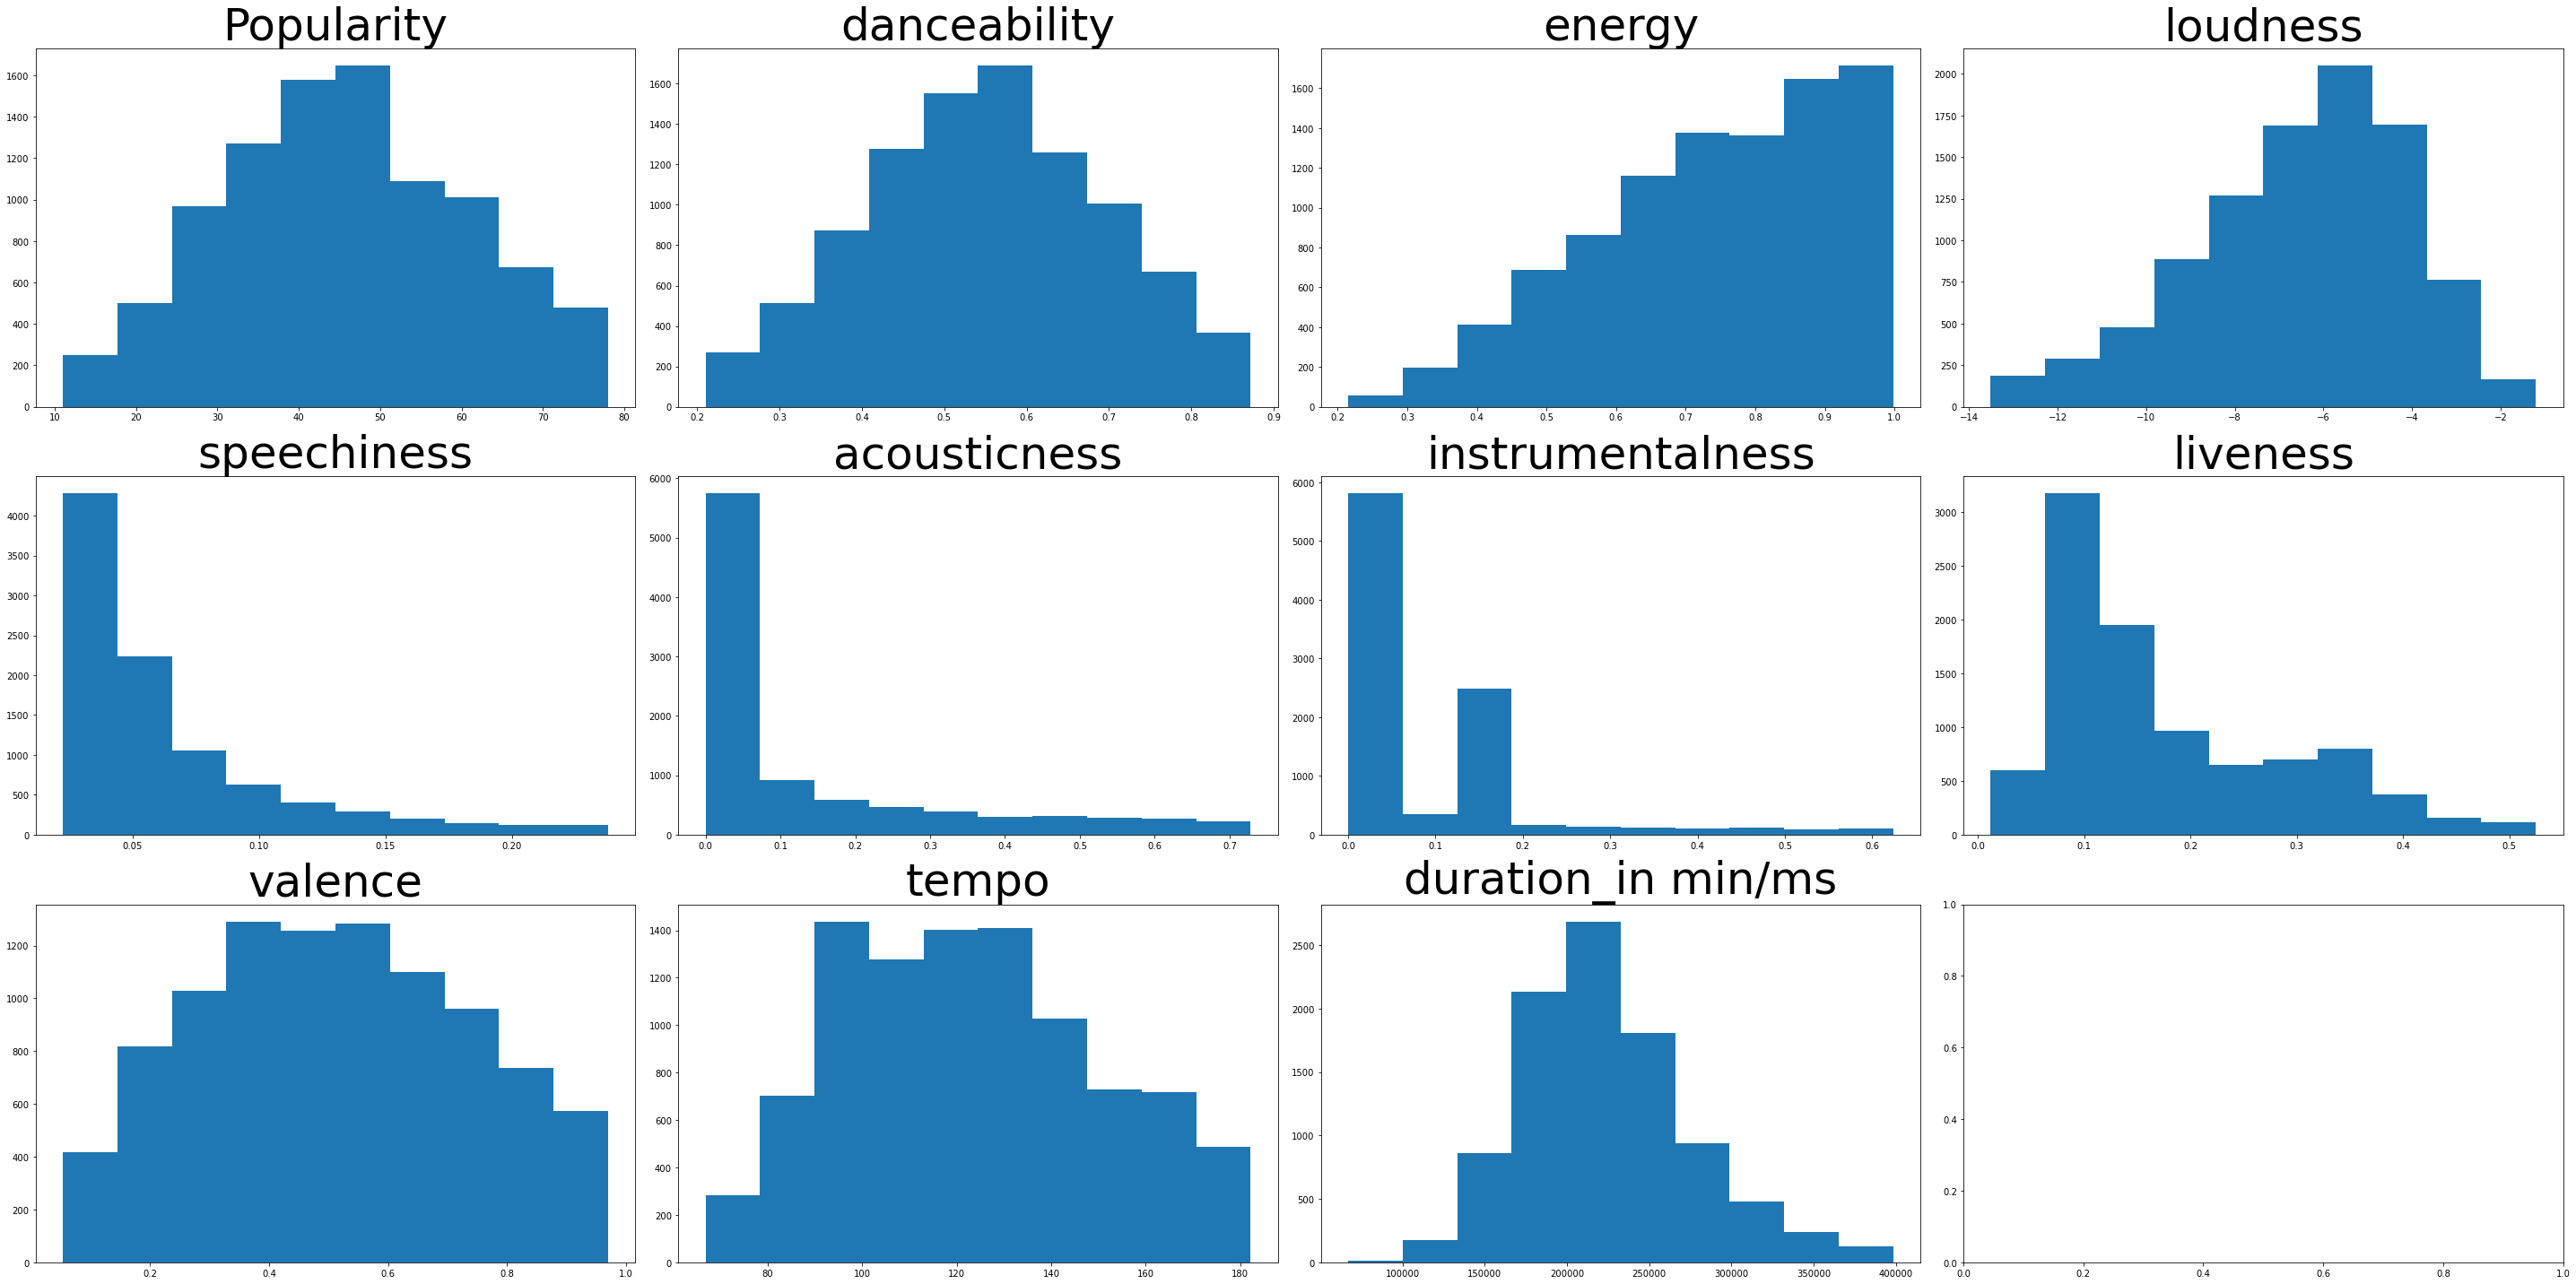

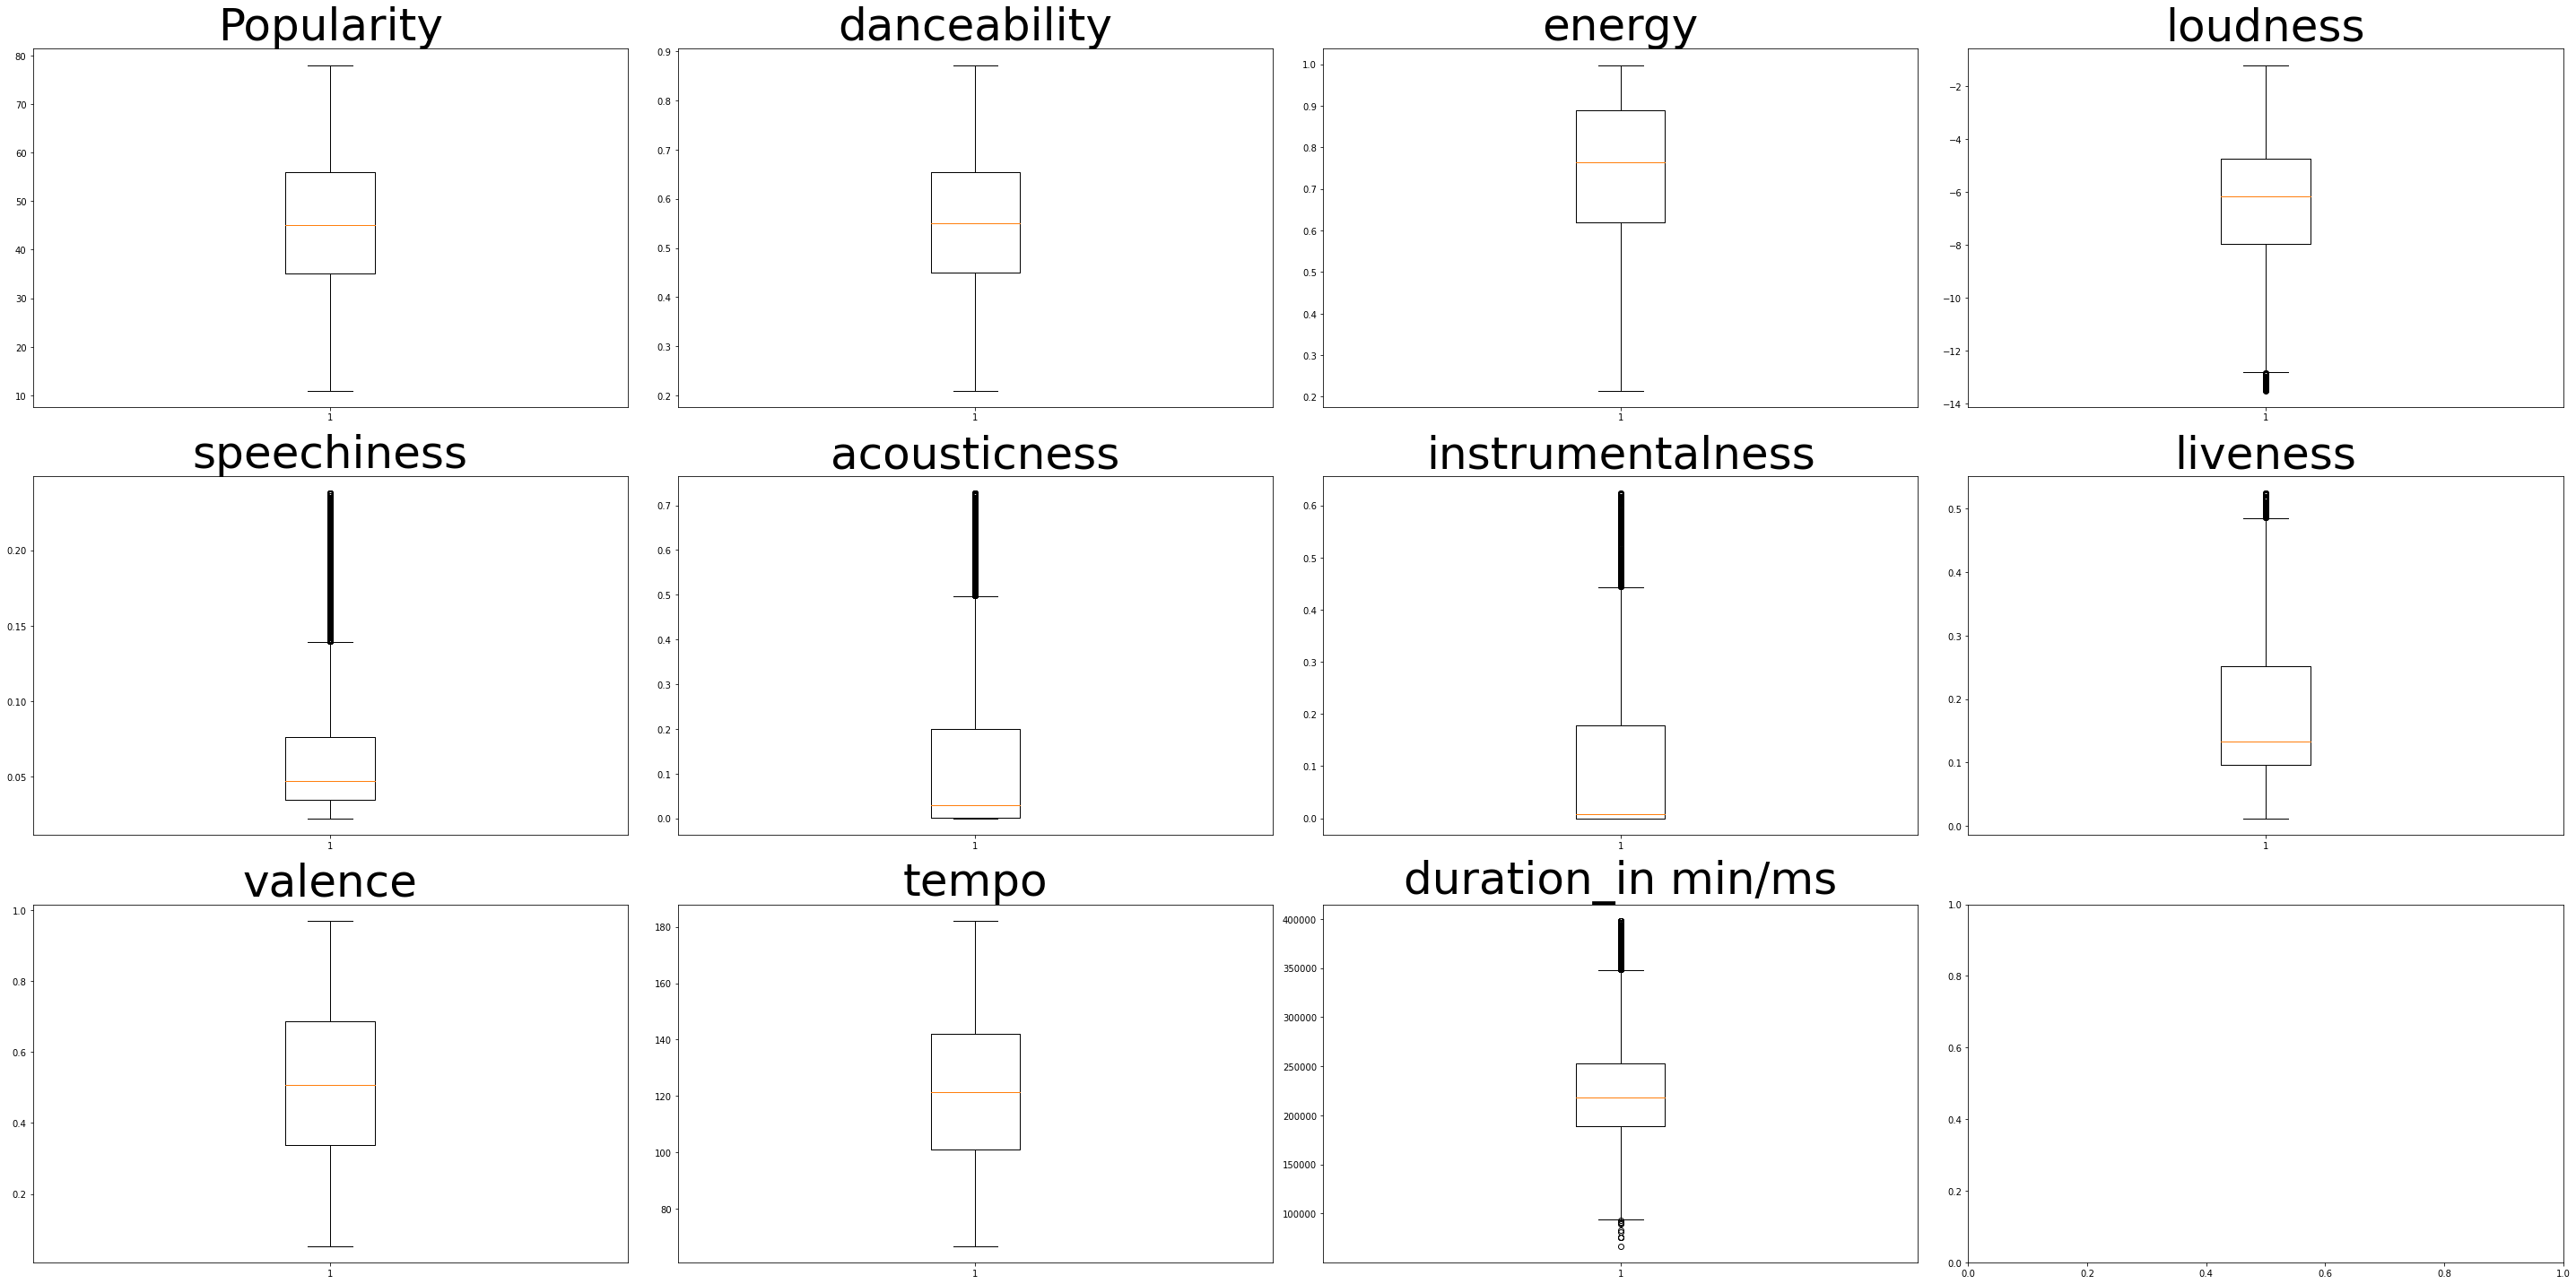

In [275]:
filtered_data_exp = remove_outliers(data_new, num_features, threshold=2)
draw_histplot(filtered_data_exp, num_features, 3, 4, 4), draw_boxplot(filtered_data_exp, num_features, 3, 4, 4), filtered_data_new.shape;

Попробовав разные варианты трешхолда я не увидел изменений в количестве выбросов, однако количество самих наблюдений в данных очень сильно снизилось. 

В таком случае я воспользуюсь данными, полученными вторым способом с трешхолдом равным 3. 

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [276]:
columns = cat_features + num_features
X, y = filtered_data_new[columns].drop('Class', axis=1), filtered_data_new['Class']

Осуществим препроцессинг наших данных

In [277]:
scaler = StandardScaler()
encoder = LabelEncoder()

numeric_cols = X.columns[3:]
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

category_cols = X.columns[:3]
X[category_cols] = X[category_cols].apply(encoder.fit_transform)

Создадим дерево и найдем оптимальные гиперпараметры

In [283]:
dec_tree = DecisionTreeClassifier()

param_grid = {'max_depth': [2, 4, 6, 8],
              'min_samples_split': [2, 4, 6, 8]}

grid_search = GridSearchCV(dec_tree, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'min_samples_split': [2, 4, 6, 8]})

In [284]:
print("Наилучшие гиперпараметры:", grid_search.best_params_)
print("Accuracy:", grid_search.best_score_)

Наилучшие гиперпараметры: {'max_depth': 8, 'min_samples_split': 6}
Accuracy: 0.460977206879959


В итоге получаем значение метрики, основанной на accuracy score, равное 0.46, что свидетельствует о отм, что модель не очень хорошо классифицирует наши данные. 

Ради интереса, попробуем построить дерево для датасета с удаленными выбросами. 

In [280]:
columns = cat_features + num_features
X_wna, y_wna = filtered_data[columns].drop('Class', axis=1), filtered_data['Class']

scaler = StandardScaler()
encoder = LabelEncoder()

numeric_cols = X_wna.columns[3:]
X_wna[numeric_cols] = scaler.fit_transform(X_wna[numeric_cols])

category_cols = X_wna.columns[:3]
X_wna[category_cols] = X_wna[category_cols].apply(encoder.fit_transform)

dec_tree = DecisionTreeClassifier()

param_grid = {'max_depth': [2, 4, 6, 8],
              'min_samples_split': [2, 4, 6, 8]}

grid_search = GridSearchCV(dec_tree, param_grid=param_grid, cv=5)
grid_search.fit(X_wna, y_wna)

print("Наилучшие гиперпараметры:", grid_search.best_params_)
print("Accuracy:", grid_search.best_score_)

Наилучшие гиперпараметры: {'max_depth': 8, 'min_samples_split': 8}
Accuracy: 0.44431173936368146


Заметим, что тут значение метрики получилось чуть, но хуже, что в принципе может подтверждать правильность рассуждений приведенных выше. 

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

Воспользуемся логистической регрессией, а именно методом One-vs-All.

In [252]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели логистической регрессии
model = LogisticRegression(multi_class='ovr')
model.fit(X_train, y_train)

# Прогнозирование классов на тестовой выборке
y_pred = model.predict(X_test)

# Оценка точности классификации
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность классификации: {accuracy}")

Точность классификации: 0.46429656639319355


Точность классификации такая же, как в нашем первом случае.

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. С недавнего времени я полюбил Шрека, в начале учебного года даже пересмотрел все части, причем изучал их очень досканально. Нужно мне это было, потому что я занимался организацией предпосвящения в студенты и как раз тематикой стал Шрек, которого я и сыграл.

![](1.PNG)

2. Если вспоминать российские фильмы или сериалы, то вот мои топы: 
- Сериалы: Кухня/Отель Гранд, Молодежка, Вампиры средней полосы, Триггер
- Фильмы: Мастер и Маргарита (новый), больше ничего и не вспомнилось)

3. А из зарубежного: 
- Сериалы: Очень странные дела, Хороший доктор (первые два сезона)
- Фильмы: Поймай меня, если сможешь; все фильмы с Джиомо Керри, кроме Тупой и еще Тупее; раньше фанател по Звездным войнам; также два корейских фильма: Паразиты, Таксист (2017)